In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../csv/data_wramling_final.csv")
data = df.copy()

In [3]:
data.drop(columns=['Unnamed: 0'],inplace=True)
data.drop(index=data.query("dormitorios>6 or area>600 or precioxm2>120 or precioxm2<8").index,inplace=True)
data.drop(index=data.query("dormitorios<=2 and banos==1 and area>=160").index,inplace=True)
data.drop(index=data.query("dormitorios<=2 and banos==2 and area>=250").index,inplace=True)
data.drop(index=data.query("precio<600").index,inplace=True)

In [4]:
data_copia = data.copy()
data_copia["dorm_ban"] = [str(dorm)+","+str(ban) for dorm,ban in data_copia[['dormitorios','banos']].values]
count = data_copia["dorm_ban"].value_counts().sort_values(ascending=True)
distribuciones_raras = pd.Series(count[count<=3].index)
queries = distribuciones_raras.apply(lambda x: "dormitorios=="+x.split(",")[0]+" and banos=="+x.split(",")[1])
indices = []
for query in queries:
    indices += data.query(query).index.tolist()
data.drop(index=indices,inplace=True)

Eliminamos distribuciones raras de dormitorios y baños.

In [5]:
data_distrito_out = data.groupby('distrito')['precioxm2'].apply(lambda x:
                                                                x.quantile(0.75) + 2.5*(x.quantile(0.75)-x.quantile(0.25))
                                                                )

for dist,max in data_distrito_out.items():
    outliers = data.query(f"distrito=='{dist}' and precioxm2>{max}")
    indices = outliers.index
    data.drop(index=indices,inplace=True)

Eliminamos los precioxm2 que se encuentren muy por encima de las distribuciones "normales"

Ahora veremos la informacion que nos proporciona cada variable.

- **fecha_publicacion**: Mes actual = 0, mes pasado = 1.

- **baños**: Número total de baños en el departamento. Es una variable relevante para la valoración de la propiedad, ya que más baños suelen estar asociados con propiedades más grandes o de mayor precio.

- **dormitorios**: Número total de dormitorios en el departamento. Es una variable clave para la clasificación de los departamentos según su tamaño y para predecir su precio, ya que más dormitorios generalmente indican un mayor espacio habitable.

- **antiguedad_categoria**: Variable categórica que clasifica la antigüedad del departamento en diferentes grupos según su edad. Puede representar categorías como "nuevo", "reciente", "antiguo", "desconocido", etc. Su utilidad radica en capturar patrones de depreciación o preferencia por propiedades más nuevas.

- **precio**: Precio del departamento expresado en soles . Es la variable objetivo en un problema de predicción de precios de departamentos en alquiler.

- **distrito**: Distrito de Lima donde se encuentra el departamento. Es una variable categórica que puede ser relevante debido a la variabilidad de precios entre distritos por factores como accesibilidad, seguridad, demanda y nivel socioeconómico.

- **latitud y longitud (coordenadas)**: Coordenadas geográficas del departamento, utilizadas para identificar su ubicación en el mapa. Estas variables pueden emplearse para análisis espaciales y para calcular la cercanía a puntos de interés (parques, centros comerciales, estaciones de transporte, etc.).

- **dirección**: Dirección exacta del departamento según la información proporcionada en el anuncio. Puede incluir calle, número y referencia adicional. Su utilidad depende del nivel de detalle y precisión con el que esté registrada.

- **precisión**: Valor obtenido de la API de geocodificación que indica la precisión de las coordenadas geográficas obtenidas para la dirección del departamento. Puede tomar valores como:
  - **ROOFTOP**: Precisión máxima, la ubicación se encuentra exactamente en el techo del edificio.
  - **GEOMETRIC_CENTER**: Coordenadas corresponden al centro geométrico del área o edificio.
  - **RANGE_INTERPOLATED**: Ubicación estimada basada en interpolaciones entre puntos conocidos.
  - **APPROXIMATE**: Ubicación aproximada sin una precisión exacta.

- **type**: Tipo de ubicación detectado por la API de geocodificación. Puede representar diferentes tipos de lugares, como:
  - **street_address**: Dirección específica.
  - **establishment**: Lugar comercial o institucional.
  - **premise**: Conjunto de edificios o condominios.
  - **cafe, doctor, clothing_store, etc.**: Categoría del lugar si la ubicación coincide con un tipo de negocio o servicio.

- **descripción**: Texto descriptivo del anuncio proporcionado por el vendedor. Puede incluir detalles sobre la propiedad, como número de dormitorios y baños, ubicación, vista, piso, acabados, áreas comunes, cercanía a servicios, entre otros. Esta variable puede ser útil para análisis de texto y extracción de características clave mediante procesamiento de lenguaje natural (NLP).

### 0. Formacion de grupos

Primero vamos a analizar y segmentar los departamentos en alquiler utilizando técnicas de clustering. El objetivo es identificar grupos homogéneos que compartan características similares en términos de dormitorios, baños, área y precio, lo que ayudará a entender cómo estas variables influyen en el valor del alquiler.

In [6]:
X = data[['dormitorios','banos','area','precio']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"Varianza total explicada: {np.sum(pca.explained_variance_ratio_)*100:.2f} %" )

Varianza total explicada: 89.81 %


Hemos escalado los datos para que todas las variables tengan el mismo peso, luego hemos hecho una reducción de la dimensionalidad con PCA a 2 componentes para poder visualizar la grafica, ademas se tuvo en cuenta que la correlacion entre estas variables era considerable lo que dio como resultado una varianza total explicada es del 90%. 

In [7]:
inercias = []
silhouette_scores = []
davies_bouldin_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    kmeans.fit(X_pca)

    # Guardar la inercia
    inercias.append(kmeans.inertia_)
    
    # Calcular y guardar el coeficiente de silueta
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X_pca, labels))

    # Calcular y guardar el índice Davies-Bouldin
    davies_bouldin_scores.append(davies_bouldin_score(X_pca, labels))

Hemos entrenado los datos con diferentes números de cluster para poder determinar cual es óptimo que obtiene un mejor resultado para la inercia, coeficiente silueta y el indice de davies-bouldin, estos miden la distancia intra-inter cluster que se necesita para poder determinar que tan compactos y separados están los grupos.

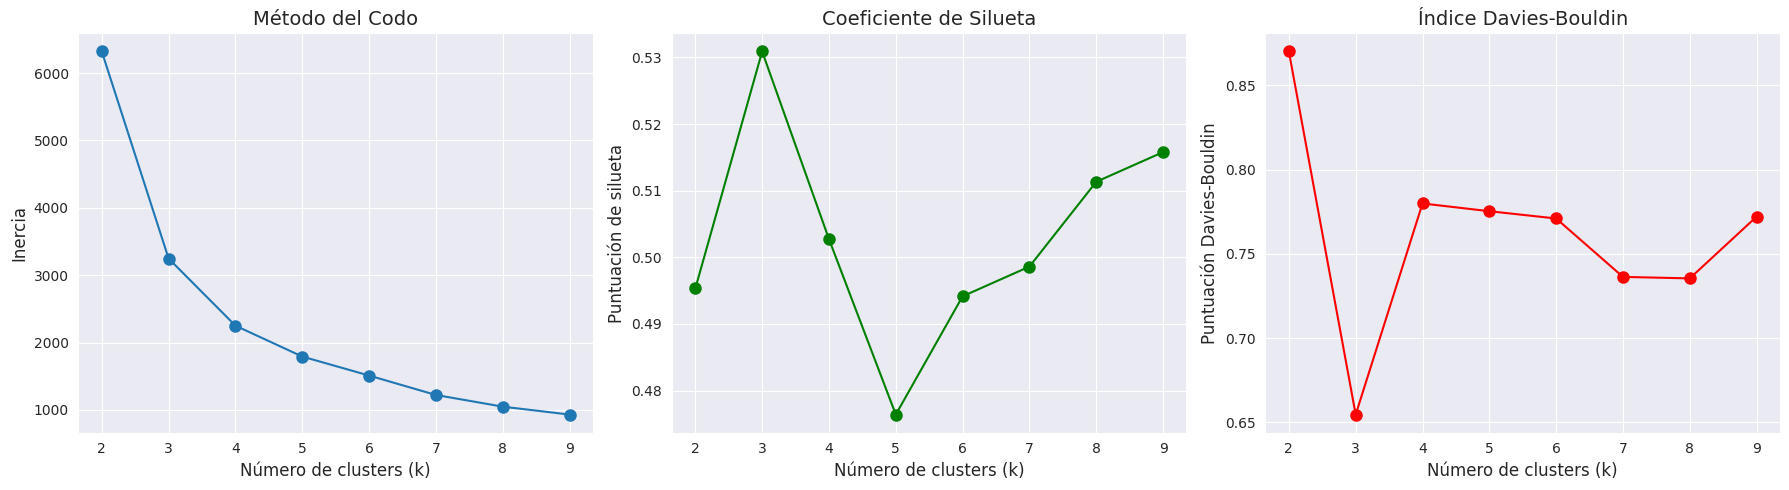

In [8]:
# 4. Visualizar los resultados
# -----------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico del método del codo
axes[0].plot(k_range, inercias, 'o-', markersize=8)
axes[0].set_title('Método del Codo', fontsize=14)
axes[0].set_xlabel('Número de clusters (k)', fontsize=12)
axes[0].set_ylabel('Inercia', fontsize=12)
axes[0].grid(True)

# Gráfico del coeficiente de silueta
axes[1].plot(k_range, silhouette_scores, 'o-', markersize=8, color='green')
axes[1].set_title('Coeficiente de Silueta', fontsize=14)
axes[1].set_xlabel('Número de clusters (k)', fontsize=12)
axes[1].set_ylabel('Puntuación de silueta', fontsize=12)
axes[1].grid(True)

# Gráfico del índice Davies-Bouldin
axes[2].plot(k_range, davies_bouldin_scores, 'o-', markersize=8, color='red')
axes[2].set_title('Índice Davies-Bouldin', fontsize=14)
axes[2].set_xlabel('Número de clusters (k)', fontsize=12)
axes[2].set_ylabel('Puntuación Davies-Bouldin', fontsize=12)
axes[2].grid(True)

plt.tight_layout()
plt.show()

Como podemos ver en la grafica el mejor valor es el de k=3.

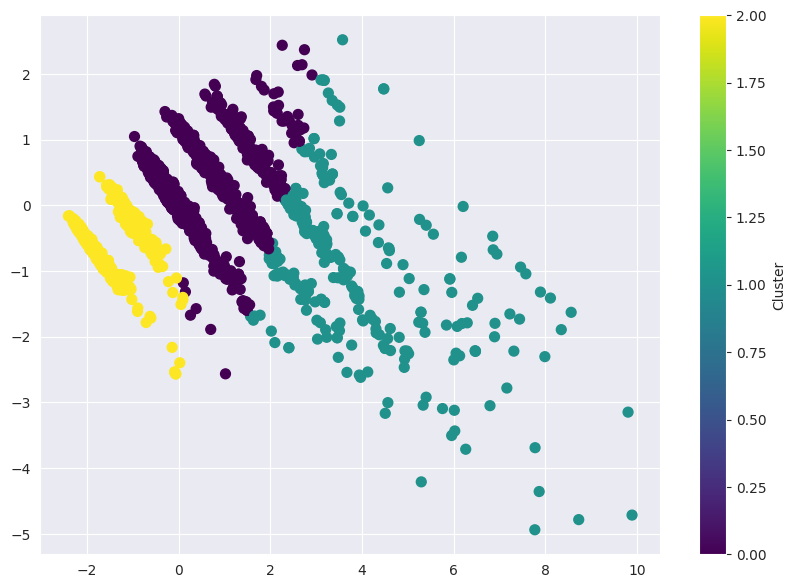

In [9]:
optimal_k = 3
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_optimal.fit_predict(X_pca)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=50, cmap='viridis')
plt.colorbar(scatter, label='Cluster')

Podemos apreciar a nuestros 3 clusters en la grafica, la separacion no es tan clara, sin embargo, es la que mejor se ajusta.

In [10]:
data_copia = data.copy()

data_copia['lima_top'] = np.where(data['distrito'].isin(['miraflores','san-isidro','barranco']),1,0)
data_copia['cluster'] = cluster_labels

descriptivos = ['median','mean','std',]
columnas = ['dormitorios','banos','area','precio']
agg_ = {"lima_top":["count","mean"]}
agg_.update({i:descriptivos for i in columnas})
lima_top_promedio = np.mean(data_copia['lima_top'].mean().round(2))
print(f"% de departamentos pertenecientes a lima top {lima_top_promedio*100:.2f}%")
data_copia.groupby("cluster").agg(agg_).T.round(2)

% de departamentos pertenecientes a lima top 29.00%


cluster                   0        1        2
lima_top    count   1859.00   284.00  1172.00
            mean       0.24     0.55     0.31
dormitorios median     3.00     3.00     1.00
            mean       2.62     3.22     1.26
            std        0.54     0.59     0.44
banos       median     2.00     3.00     1.00
            mean       2.13     3.06     1.06
            std        0.47     0.76     0.24
area        median    90.00   220.00    50.00
            mean      94.08   237.60    56.34
            std       29.94    77.72    18.78
precio      median  2800.00  7500.00  2035.00
            mean    3031.30  8236.02  2112.23
            std     1078.60  2893.34   745.63

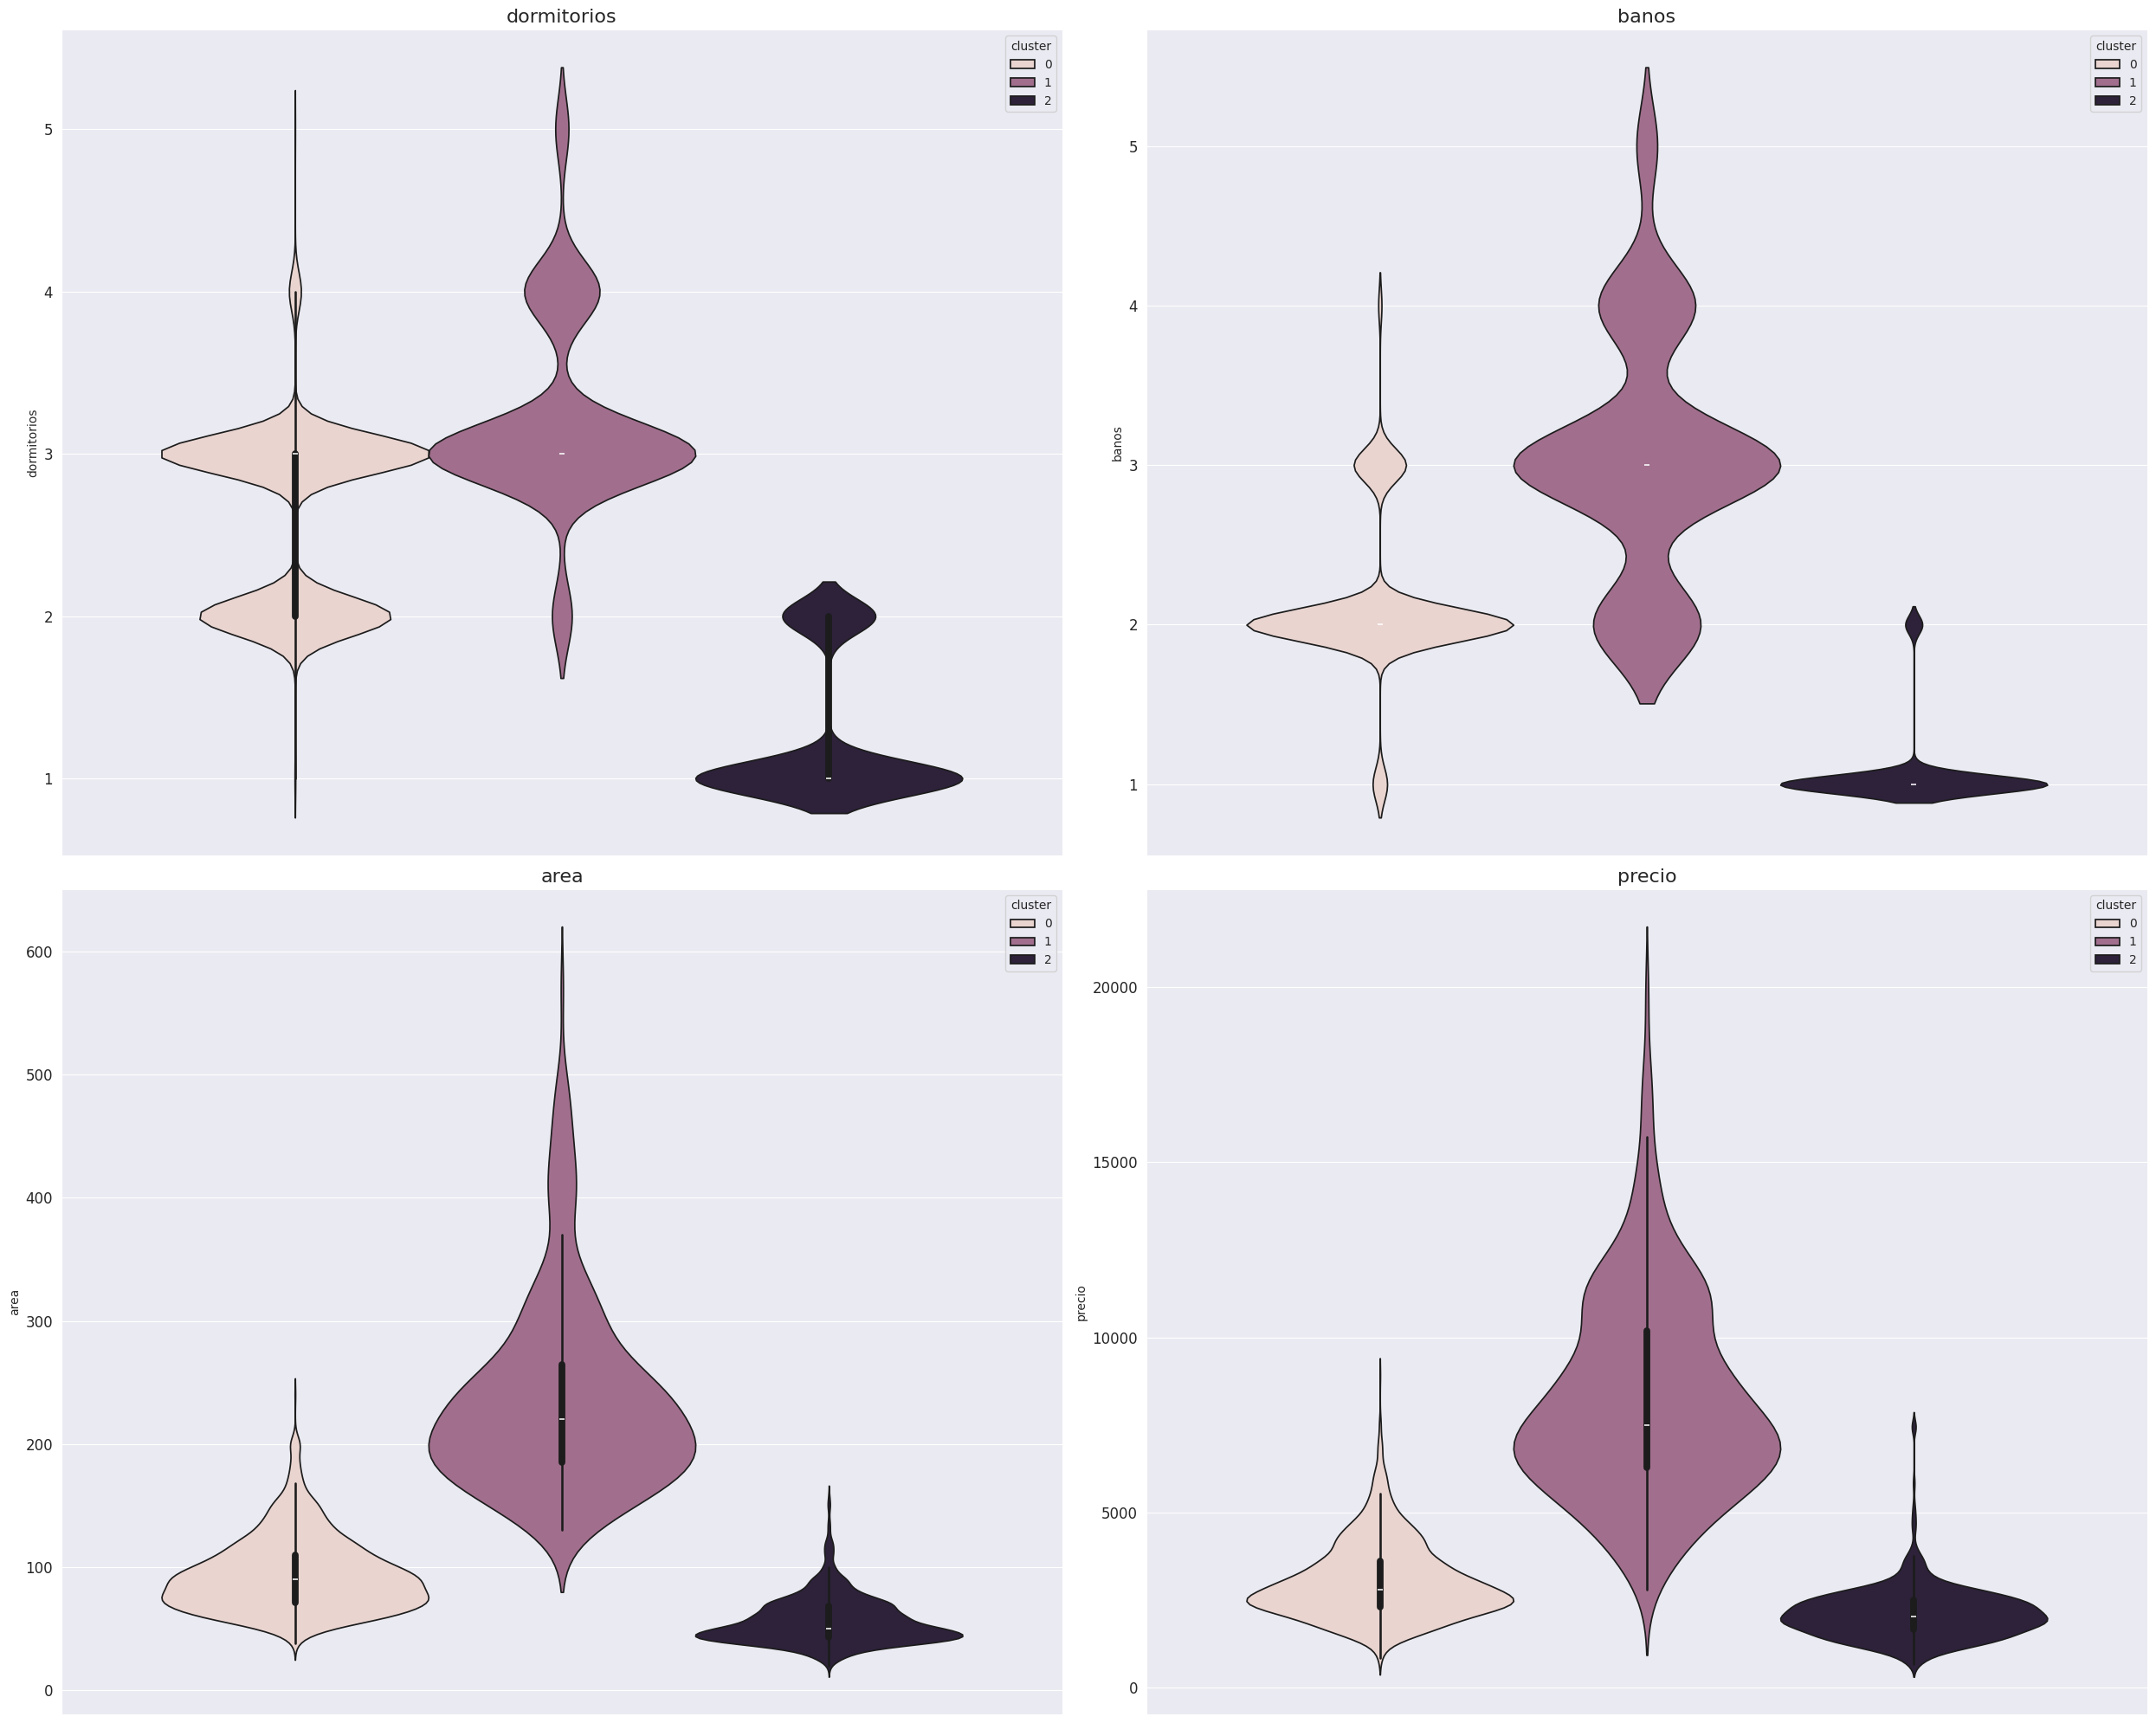

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(25, 20))

for i, col in enumerate(columnas):
    f, c = i//2, i%2
    sns.violinplot(data=data_copia,y=col,hue='cluster',ax=ax[f, c])
    ax[f][c].set_title(col, fontsize=16)
    ax[f][c].tick_params(axis='both', labelsize=12)

# Mejorar espacio entre gráficos
plt.tight_layout()
plt.show()

- 
- **cluster 0** : Este cluster contiene **departamentos pequeños** que son perfectos para una persona o una pareja sin hijos, ya que mayormente poseen **1 dormitorio**, **1 baño**, un area promedio entre **40m2 y 60 m2**, su precio se encuentra entorno a los **1500 y 3000 soles soles** en promedio.
- **cluster 1** : Este cluster contiene departamentos de **muy amplios** con areas muy grandes en su mayoria(**mayor a 200m2**), **3 o 4 dormitorios** en su mayoria, **3 o 4 baños** en su mayoria y un rango de precios bastante amplio que oscila entre los **4000 soles y 11000 soles** en promedio. El % de departamentos "lima_top" es casi el doble en este cluster, esto se da porque los departamentos lujosos presentes en estos distritos suelen ser amplios.
- **cluster 2** : Este cluster contiene **departamentos más "normales"** con un área decente entre **60m2 y 90m2** en promedio, entre **2 y 3 dormitorios**, **2 y 3 baños** y un precio promedio entre **2000 y 4000 soles**.

### 1. Analisis Univariado

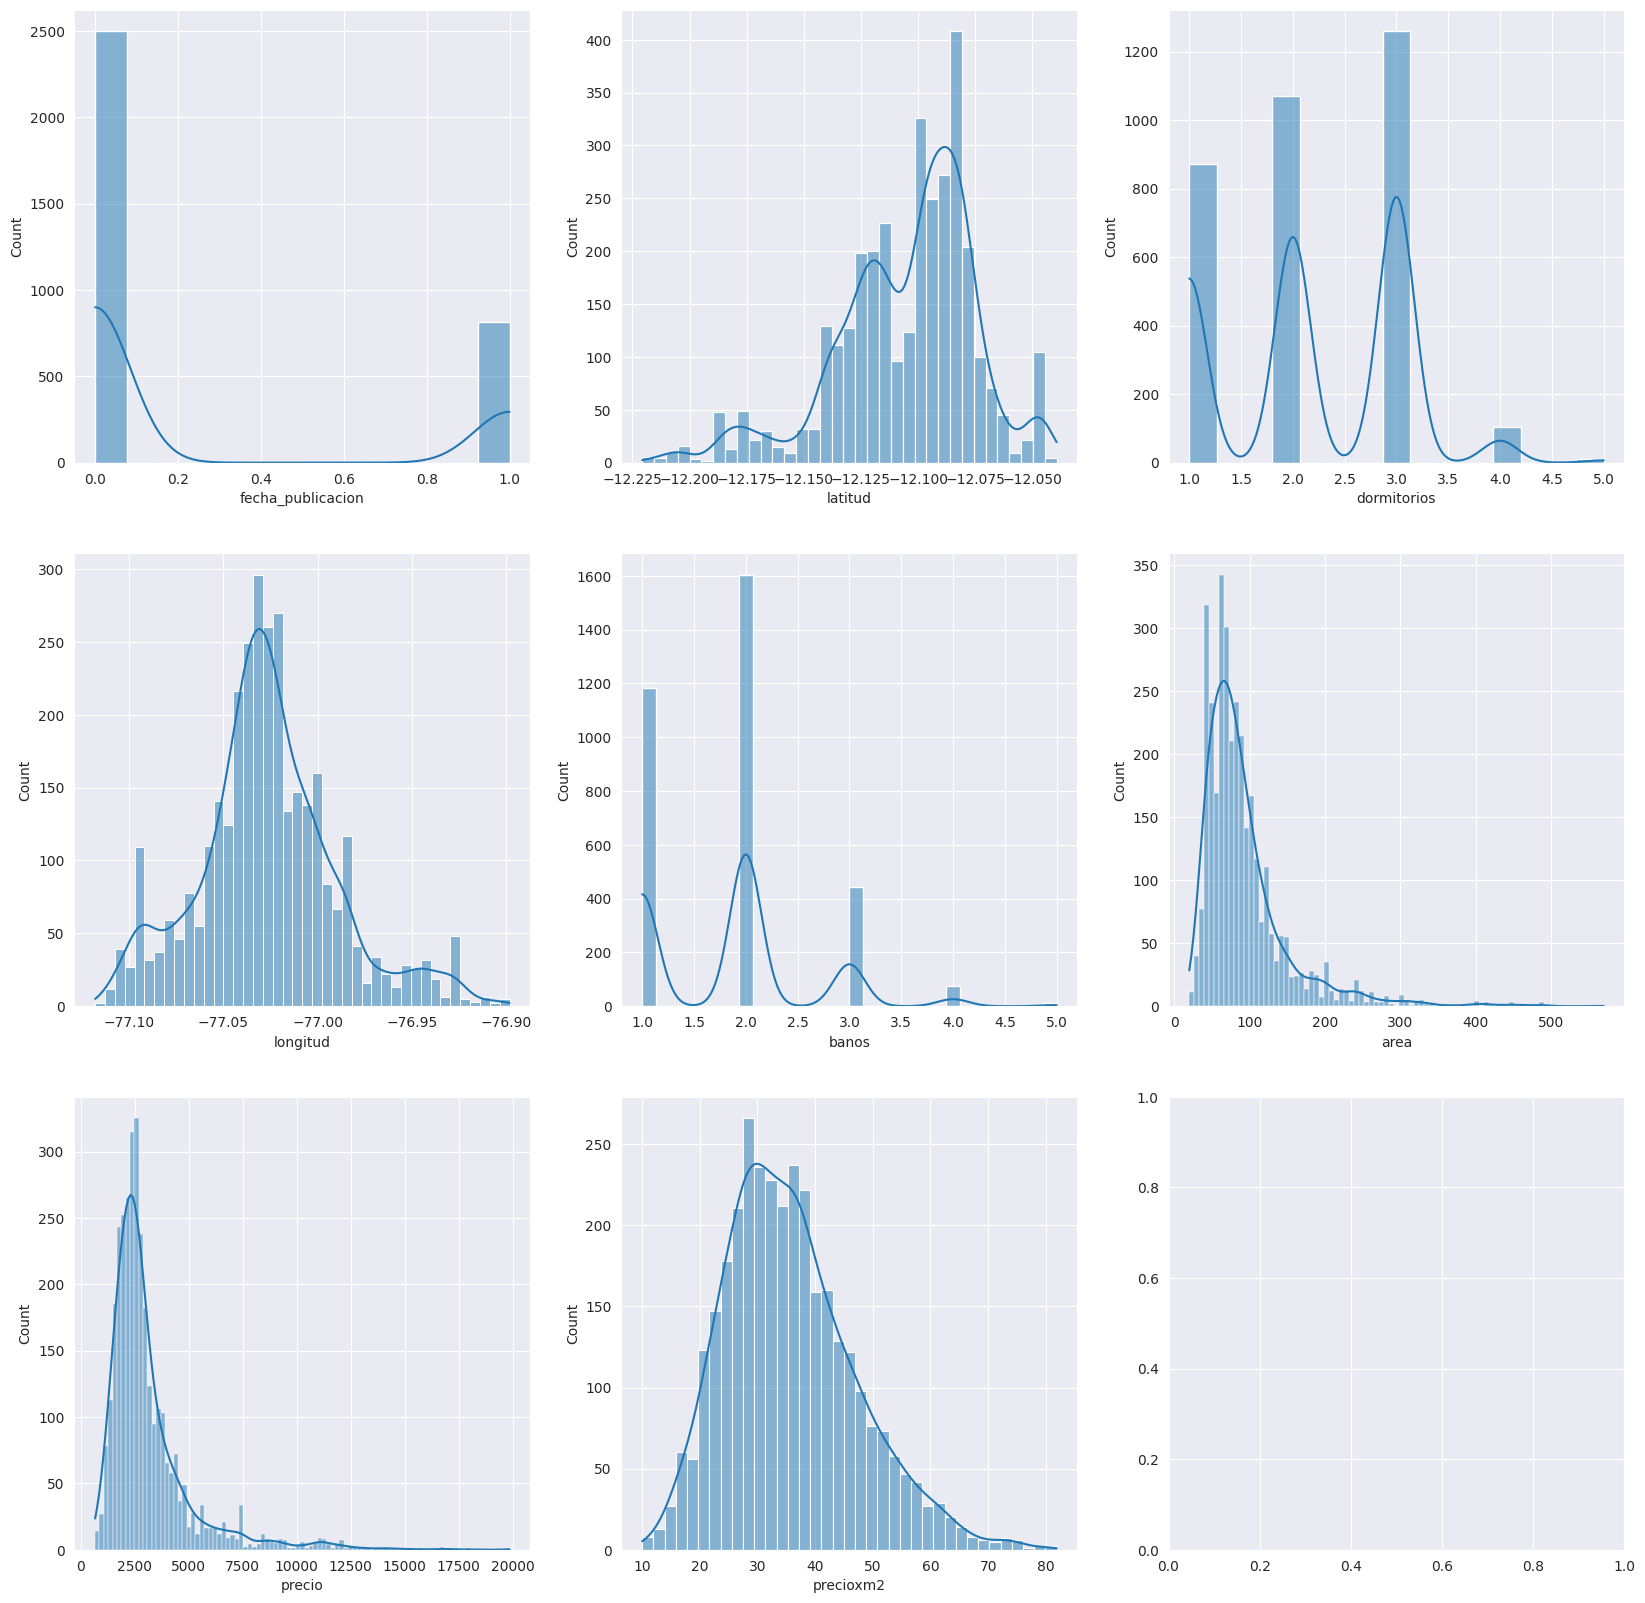

In [12]:
columnas_num = data.select_dtypes(include=['float','int']).columns
fig,ax = plt.subplots(3,3,figsize=(20,20))
for i, column in enumerate(columnas_num):
    sns.histplot(data[column], kde=True, ax=ax[i//3,i%3])
fig.show()

 A partir de las distribuciones anteriores podemos concluir

- **fecha_publicación**: Las publicaciones de este mes son considerablemente mayores a las publicaciones del mes pasado.
- **latitud**: La latitud muestra una distribución sesgada(-) con varios picos, esto puede indicar las concentraciones existentes en los diferentes distritos.
- **longitud**: La longitud muestra una distribución un poco menos sesgada(-) y con picos no tan pronunciados como la latitud.
- **dormitorios**: Se puede ver que la mayoria de departamentos poseen 2 o 3 dormitorios.
- **banos**: Se puede apreciar que la mayoria de los departamentos poseen 1 o 2 dormitorios.  
- **area**: Se puede ver que el area muestra una distribucion fuertemente sesgada(+).
- **precio**: El precio al igual que el area muestra una distribucion fuertemente sesgada(+).
- **precioxm2**: El precioxm2 muestra una distribucion ligeramente sesgada(+),

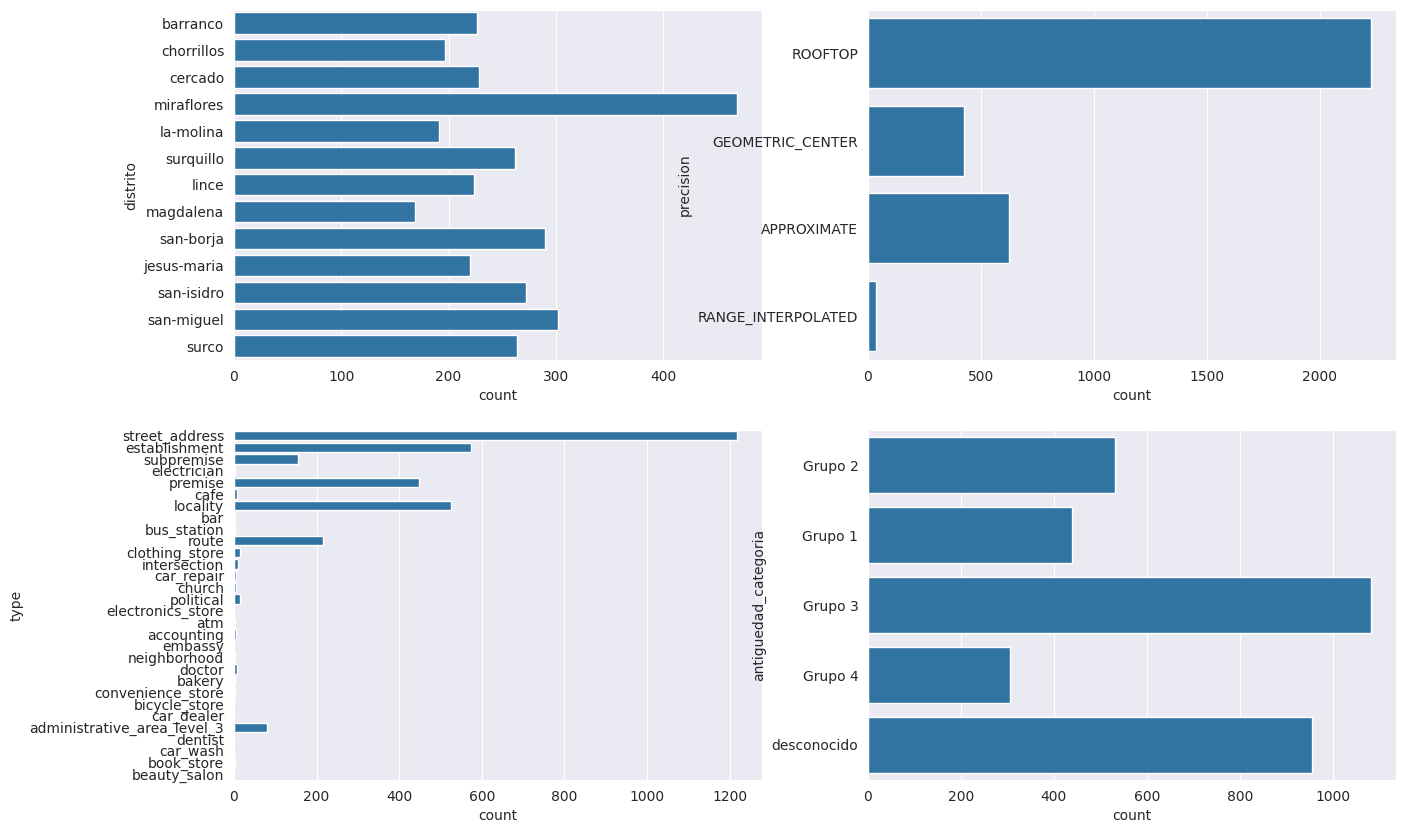

In [13]:
columnas_obj = ['distrito','precision','type','antiguedad_categoria']
fig,ax = plt.subplots(2,2,figsize=(15,10))
for i, column in enumerate(columnas_obj):
    sns.countplot(y=data[column],ax=ax[i//2,i%2])
fig.show()

### 2. Analisis de la correlacion

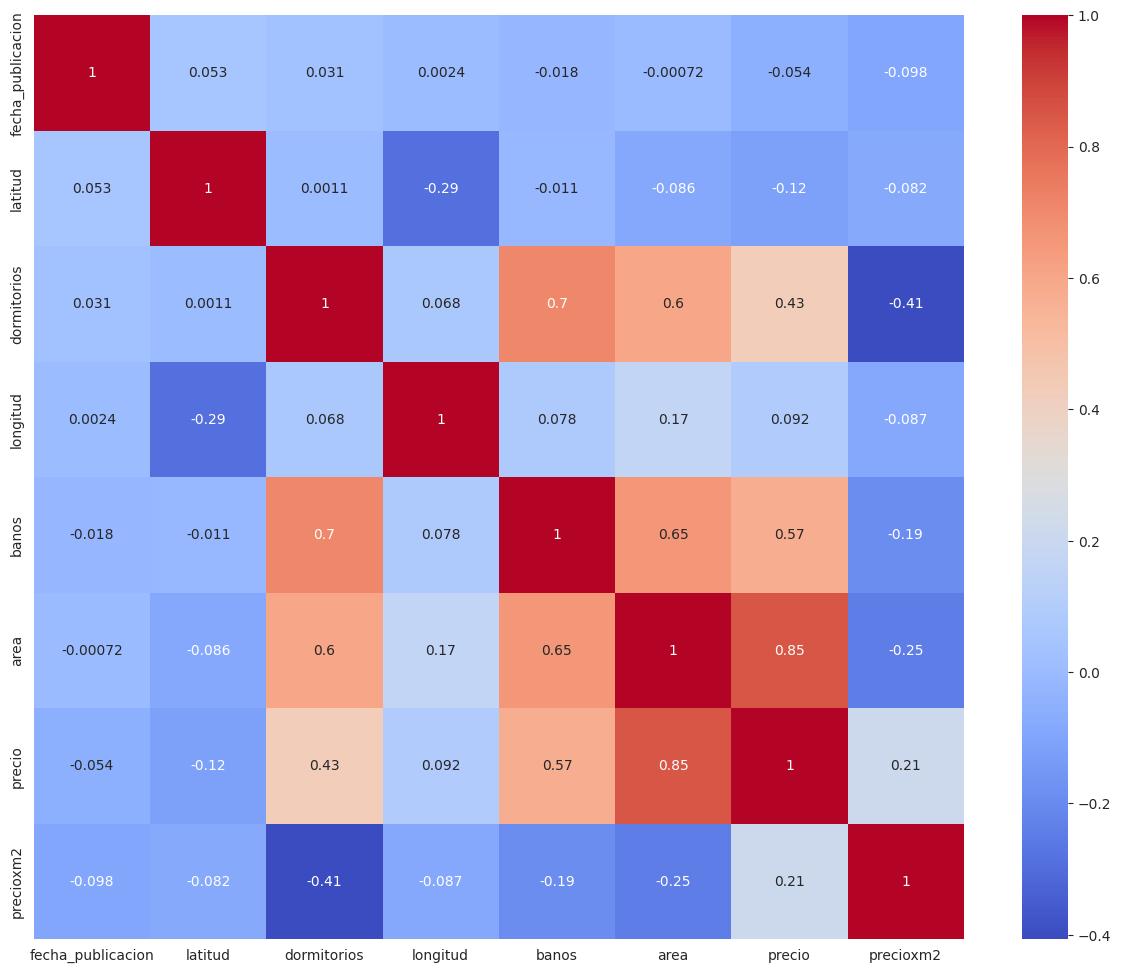

In [14]:
correlacion = data.select_dtypes(include=['float','int']).corr()
plt.figure(figsize=(15,12))
sns.heatmap(correlacion, annot=True, cmap='coolwarm')
plt.show()

### 3. Analisis Multivariado

In [15]:
visualizacion_df = data.copy()
visualizacion_df['lima_top'] = np.where(data['distrito'].isin(['miraflores','san-isidro','barranco','lince']),1,0)
visualizacion_df['dorm+ban'] = data['dormitorios'] + data['banos']
data['banos/dormitorio'] = data['banos']/data['dormitorios']
visualizacion_df['banos/dormitorio>=1'] = np.where(data['banos/dormitorio']>=1,1,0)
visualizacion_df['banosxdormitorio_cat'] = np.where(data['banos/dormitorio']<1,"<1",
                                              np.where(data['banos/dormitorio']==1,"==1",">1"))

visualizacion_df['distrito_clase'] =  visualizacion_df['distrito'].map({
    "miraflores":"clase1",
    "san-isidro":"clase1",
    "barranco":"clase1",
    "lince":"clase1",
    "magdalena":"clase2",
    "surquillo":"clase2",
    "jesus-maria":"clase2",
    "san-borja":"clase2",
    "surco":"clase2",
    "cercado":"clase3",
    "san-miguel":"clase3",
    "chorrillos":"clase3",
    "la-molina":"clase3"
})


**2.1. Precio vs Area**

Relacion entre el precio y el area de un departamento.
 

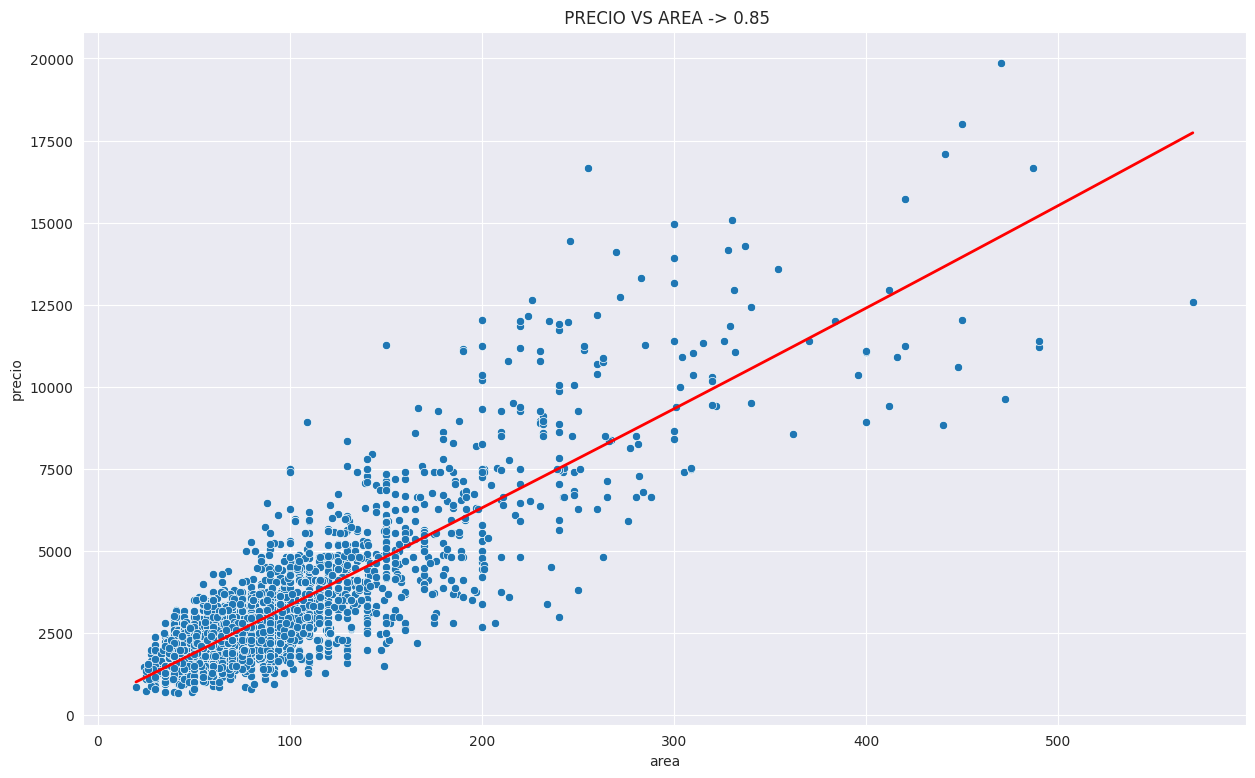

In [16]:
poly = PolynomialFeatures(degree=2)
X = visualizacion_df[['area']]
y = visualizacion_df['precio']
X_poly = poly.fit_transform(X)

modelo = LinearRegression()
modelo.fit(X_poly,y)

X_range = np.linspace(X.min(),X.max(),100).reshape(-1,1)
X_range_poly = poly.transform(X_range)
y_pred = modelo.predict(X_range_poly)

corr = visualizacion_df[['precio','area']].corr().values[0][1].round(2)
plt.figure(figsize=(15,9))
sns.scatterplot(data=visualizacion_df,x='area',y='precio')
plt.plot(X_range, y_pred, color='red', label="Ajuste Polinómico (Grado 2)", linewidth=2)
plt.title(f" PRECIO VS AREA -> {corr}")
plt.show()

Conclusión:
- Se puede apreciar una correlación alta y una **tendencia lineal positiva.**
- Podemos ver que el precio tiene una correlación alta de 0.83 con el área, sin embargo, también se observa una ligera tendencia logarítmica, lo que sugiere que, a partir de un cierto tamaño, el incremento en el precio se desacelera y deja de crecer de manera proporcional al aumento del área, hay que considerar que aqui entran otros factores en juego como el distrito, dormitorios, etc.

**2.2. Precio vs Area vs Distrito**

Relacion del precio y el area de los departamentos de un distrito.

In [17]:
visualizacion_df.groupby('distrito')['precioxm2'].describe().sort_values(by='mean',ascending=False)

count       mean        std        min        25%        50%  \
distrito                                                                    
barranco     227.0  46.818680  11.907559  22.070175  38.770833  45.981818   
san-isidro   272.0  43.098903  12.194637  22.320000  35.330978  40.310078   
miraflores   469.0  41.029348  10.075210  20.000000  33.636364  39.312500   
lince        224.0  40.436262  10.733756  11.861189  33.102679  40.716972   
magdalena    169.0  35.538787   8.756605  15.617162  29.057333  34.780000   
surquillo    262.0  34.973230   9.547034  10.991755  28.051282  35.593220   
jesus-maria  220.0  34.122122   9.946084  10.332653  27.449396  33.333333   
san-borja    290.0  32.601112   7.867302  10.057047  27.756944  31.336801   
surco        264.0  32.462036   9.212173  16.000000  25.555556  31.250000   
cercado      228.0  30.682497  10.767908  10.034347  23.323592  28.777501   
san-miguel   302.0  30.465011   7.981178  15.369231  25.000000  29.879518   
chorrillos   197.0  28.028323   9.254211  12.307692  21.126761  27.016129   
la-molina    191.0  26.464160   7.352249  12.500000  21.778712  25.315789   

                   75%        max  
distrito                           
barranco     53.991333  79.666667  
san-isidro   49.822436  80.000000  
miraflores   46.373333  77.682927  
lince        47.000000  81.871560  
magdalena    41.328571  64.870130  
surquillo    41.666667  60.526316  
jesus-maria  40.000000  60.975610  
san-borja    37.142857  59.523810  
surco        36.709184  60.975610  
cercado      37.784645  66.034483  
san-miguel   34.848485  55.813953  
chorrillos   33.333333  62.000000  
la-molina    29.250000  48.387097

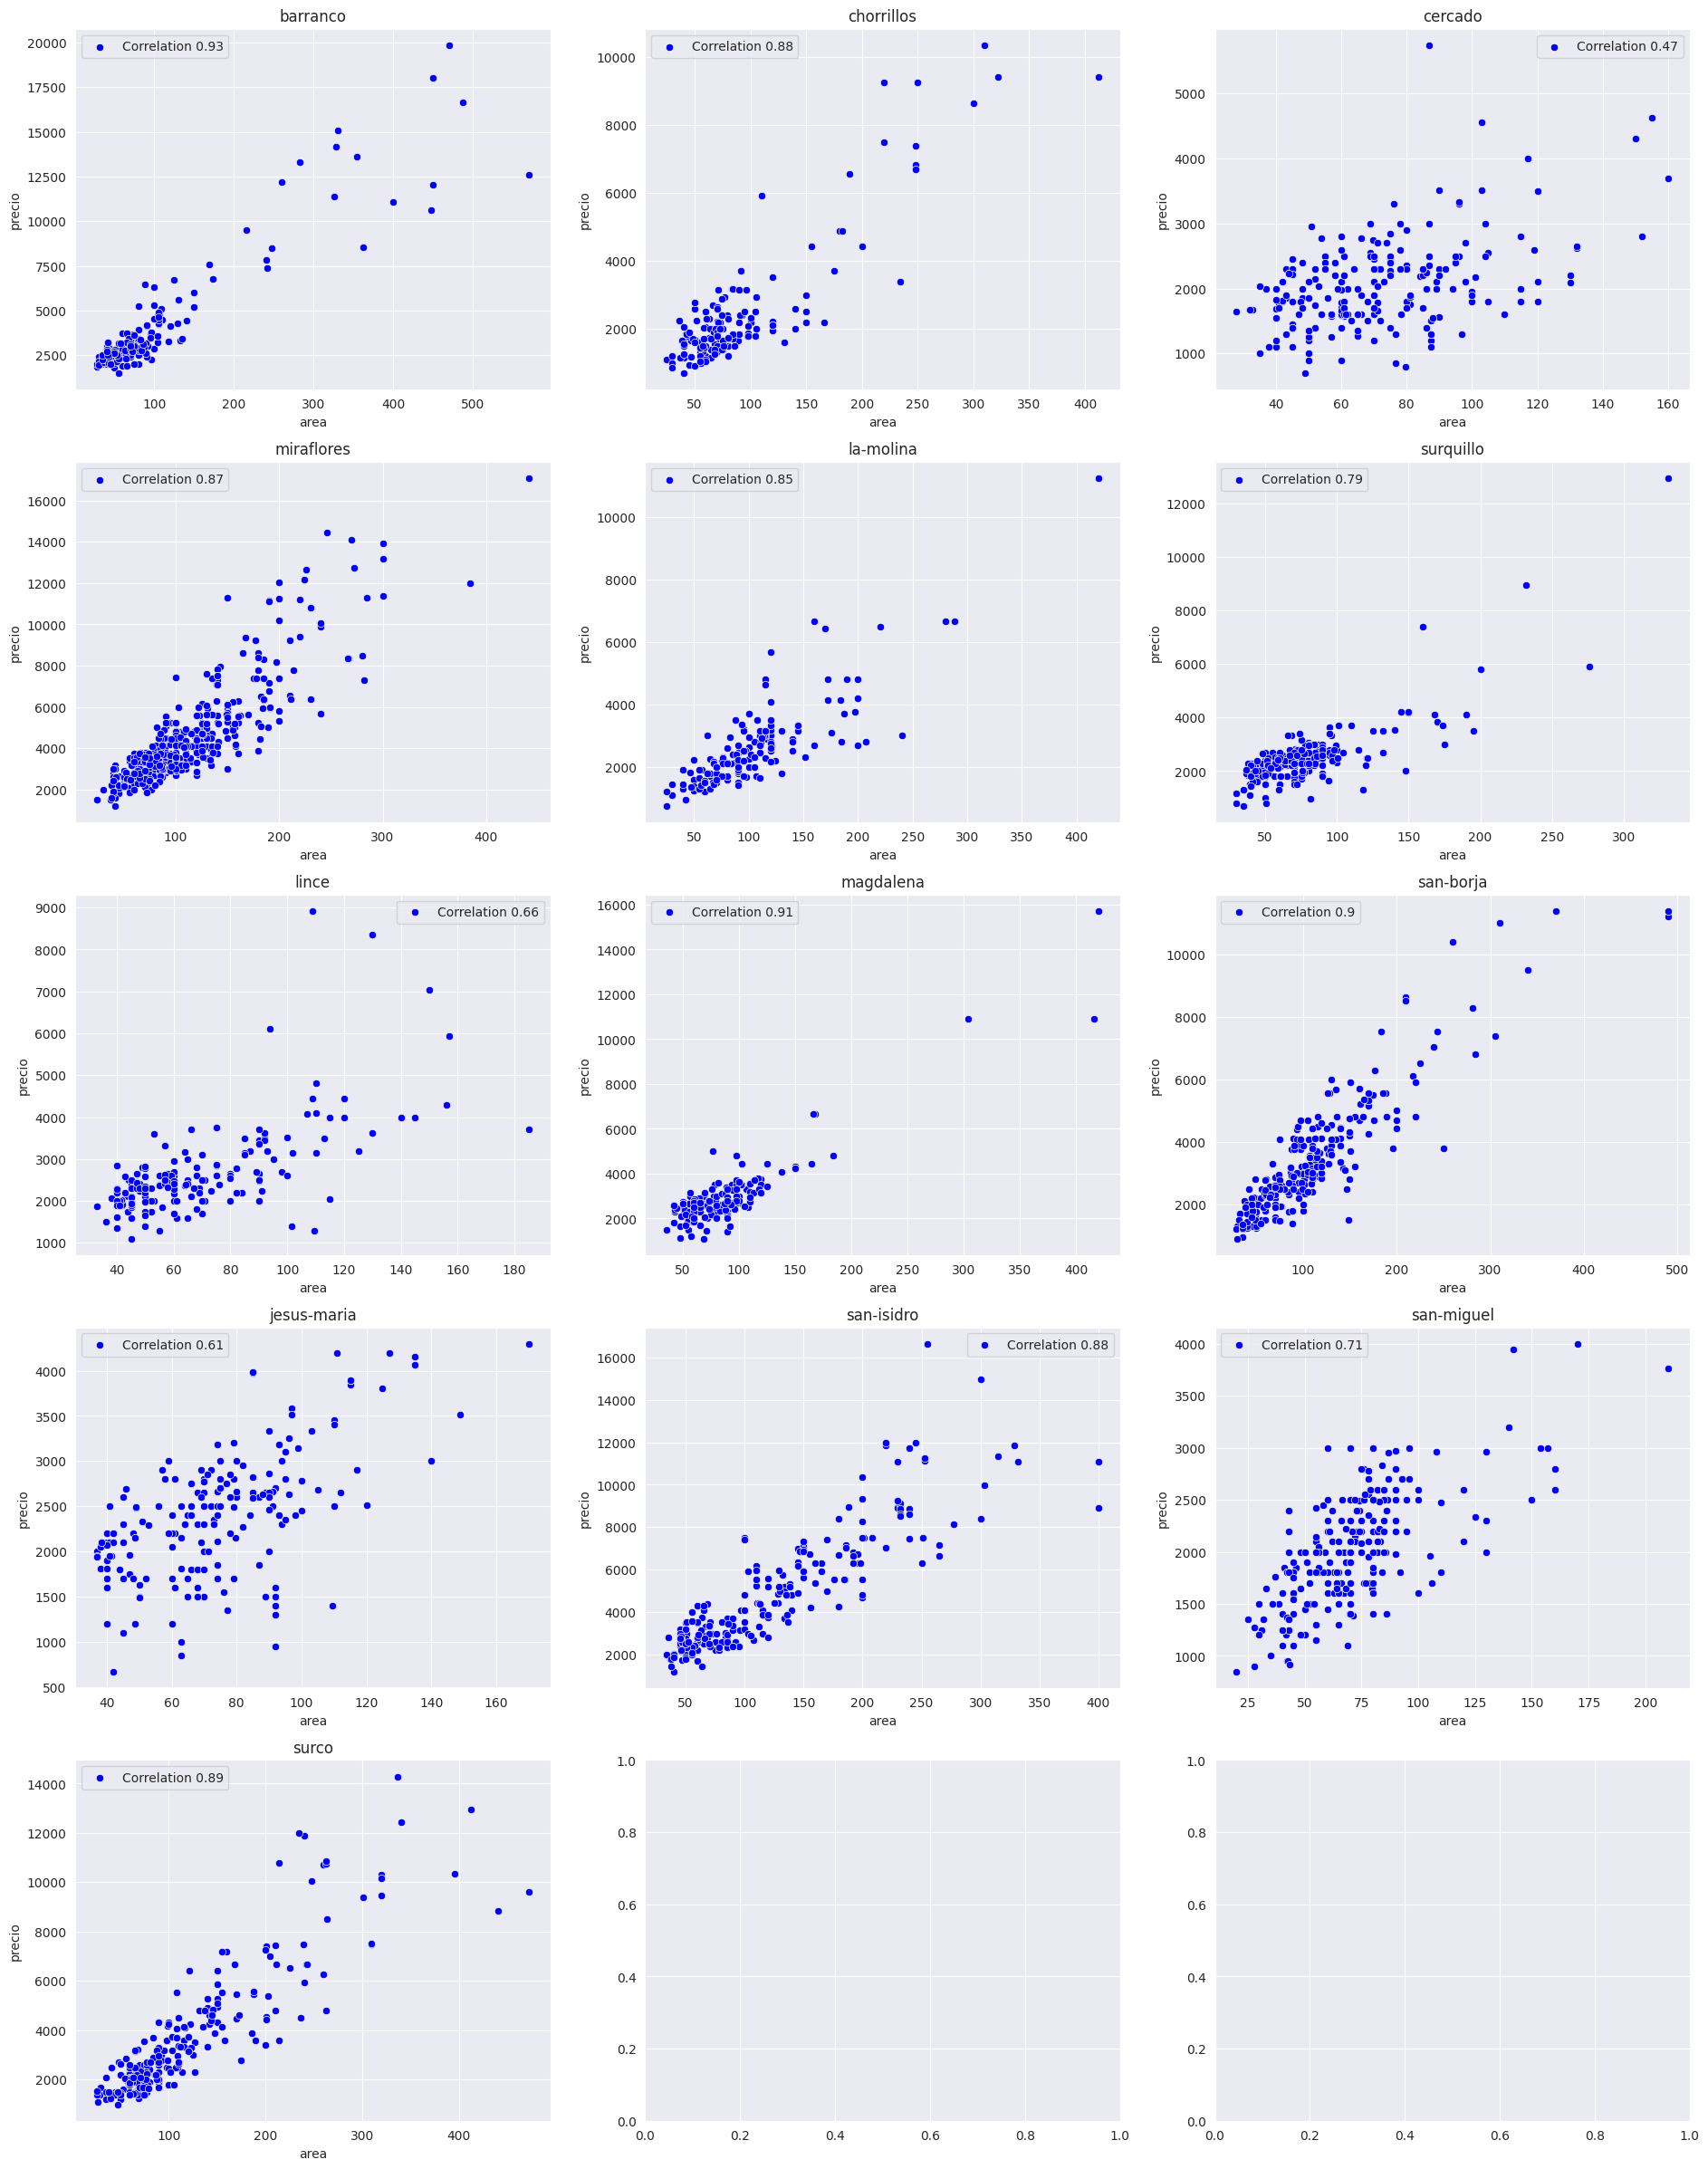

In [18]:
fig,ax = plt.subplots(5,3,figsize=(23,30))
distritos = visualizacion_df['distrito'].unique()

for i,distrito in enumerate(distritos):
    f,c = i//3,i%3
    data_distrito = visualizacion_df.query(f"distrito=='{distrito}'")
    corr_distrito = data_distrito[['precio','area']].corr().values[0][1].round(2)
    sns.scatterplot(data=data_distrito,x='area',y='precio',color='blue',ax=ax[f,c],label=f"Correlation {corr_distrito}")
    ax[f,c].set_title(f"{distrito}")
fig.show()

Conclusión:

- Se puede apreciar una **correlación alta** en los **distritos más uniformes** (que solo tienen un tipo de zonas) que en los **distritos menos uniformes** (que tienen zonas malas y buenas). En los distritos de Lima Top, se puede ver que la correlación entre el precio y el área es notable (mayor a 0.80), aquí incluimos a Barranco, Miraflores, San Isidro, Surco, San Borja, Magdalena y Chorrillos, esto indica que son distritos uniformes **(en cuanto a departamentos en alquiler)** por lo que la relación área vs precio se mantiene proporcional en la mayoría de los departamentos lo cual hace a su vez una variable muy importante para poder calcular el precio de un departamento en estos distritos, en otros distritos como Lince, Cercado o Jesus Maria las correlaciones no son tan grandes esto indica que tienen zonas más variadas, algunas mejores, otras peores, por lo que el área puede no ayudar tanto a determinar el precio de estos departamentos.

**2.3. Precioxm2 vs lima_top**

Relación del precio de cada m2 entre los departamentos pertenecientes a lima-top y los que no pertenecen a lima-top.

- Cual es el promedio de los departamentos pertenecientes a los distritos 'lima-top' y los que no pertenecen a 'lima-top'?
- La diferencia en el precioxm2 de los departamentos pertencientes a estas 2 clases de distritos es significativa?

In [19]:
visualizacion_df.groupby("lima_top")['precio'].describe().T

lima_top             0             1
count      2123.000000   1192.000000
mean       2676.434687   3999.735050
std        1578.062556   2457.921241
min         670.000000   1100.000000
25%        1800.000000   2500.000000
50%        2300.000000   3185.000000
75%        2953.150000   4500.000000
max       15725.000000  19855.000000

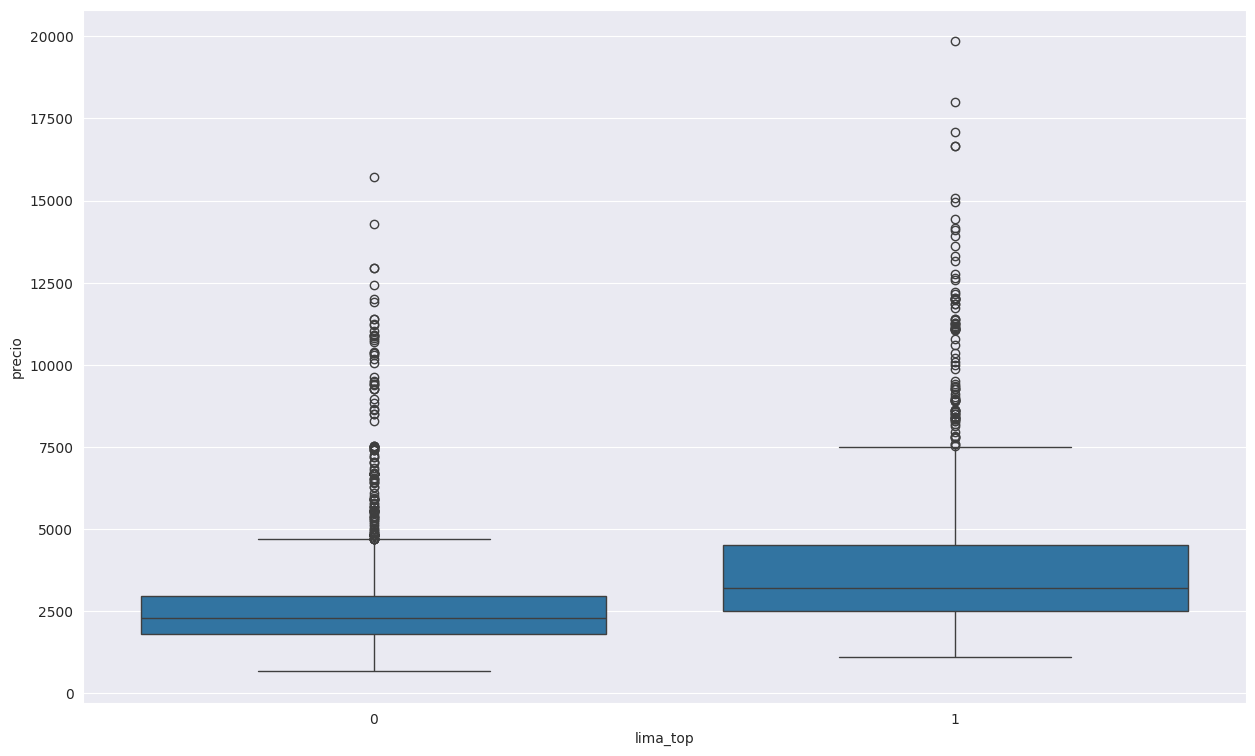

In [20]:
plt.figure(figsize=(15,9))
sns.boxplot(data=visualizacion_df,x='lima_top',y='precio')
plt.show()

Observaciones:
 
- Se puede apreciar que los departamentos en **lima_top** tienen en promedio un precio **considerablemente mayor** a los departamentos que no se encuentran en lima_top. 

- **Hipotesis: Son los precios de los departamentos de lima_top más caros en promedio que los departamentos que no son de lima_top?**

**2.4. Precioxm2 vs distrito**

Relación del precio de cada m2 en los diferentes distritos de Lima.

- Como varia el precio de cada m2 en los diferentes distritos de Lima?
- Los distritos ...?

In [21]:
distritos_ordenados = visualizacion_df.groupby('distrito')['precioxm2'].mean().sort_values(ascending=False)

In [22]:
visualizacion_df.groupby("distrito")['precioxm2'].describe().sort_values(by='mean', ascending=False)

count       mean        std        min        25%        50%  \
distrito                                                                    
barranco     227.0  46.818680  11.907559  22.070175  38.770833  45.981818   
san-isidro   272.0  43.098903  12.194637  22.320000  35.330978  40.310078   
miraflores   469.0  41.029348  10.075210  20.000000  33.636364  39.312500   
lince        224.0  40.436262  10.733756  11.861189  33.102679  40.716972   
magdalena    169.0  35.538787   8.756605  15.617162  29.057333  34.780000   
surquillo    262.0  34.973230   9.547034  10.991755  28.051282  35.593220   
jesus-maria  220.0  34.122122   9.946084  10.332653  27.449396  33.333333   
san-borja    290.0  32.601112   7.867302  10.057047  27.756944  31.336801   
surco        264.0  32.462036   9.212173  16.000000  25.555556  31.250000   
cercado      228.0  30.682497  10.767908  10.034347  23.323592  28.777501   
san-miguel   302.0  30.465011   7.981178  15.369231  25.000000  29.879518   
chorrillos   197.0  28.028323   9.254211  12.307692  21.126761  27.016129   
la-molina    191.0  26.464160   7.352249  12.500000  21.778712  25.315789   

                   75%        max  
distrito                           
barranco     53.991333  79.666667  
san-isidro   49.822436  80.000000  
miraflores   46.373333  77.682927  
lince        47.000000  81.871560  
magdalena    41.328571  64.870130  
surquillo    41.666667  60.526316  
jesus-maria  40.000000  60.975610  
san-borja    37.142857  59.523810  
surco        36.709184  60.975610  
cercado      37.784645  66.034483  
san-miguel   34.848485  55.813953  
chorrillos   33.333333  62.000000  
la-molina    29.250000  48.387097

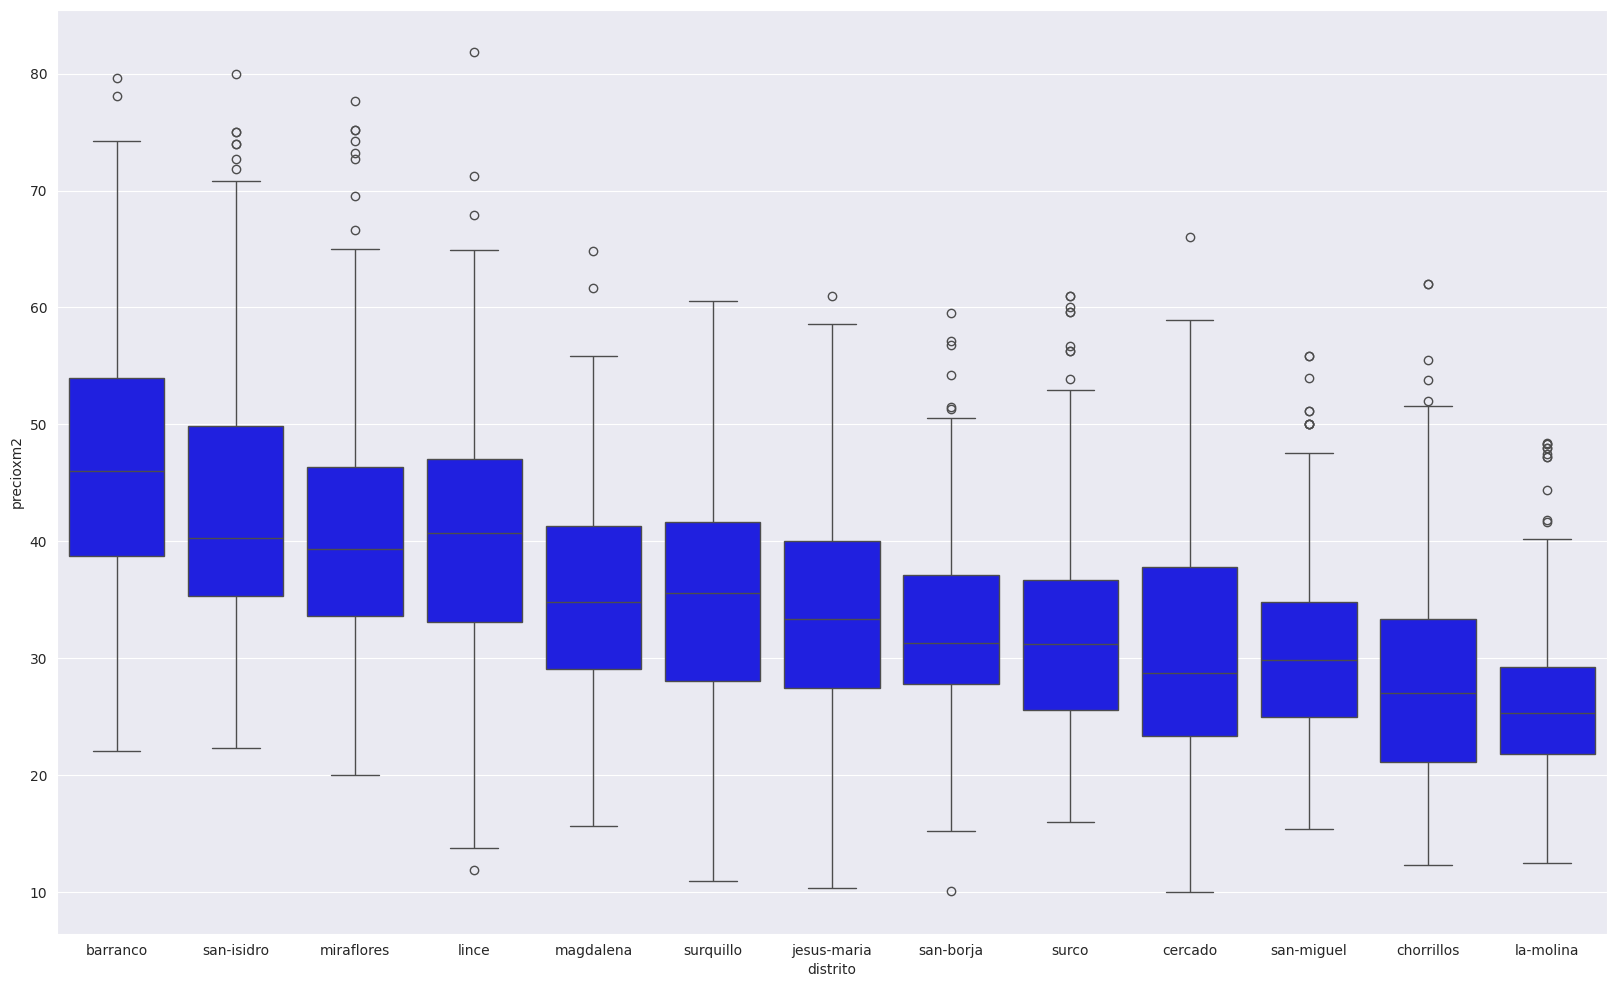

In [23]:
plt.figure(figsize=(20,12))
sns.boxplot(data=visualizacion_df,x='distrito',y='precioxm2',color='blue',order=distritos_ordenados.index)
plt.show()

Observaciones:

- En las tres primeras posiciones podemos ver claramente a los distritos de Lima-Top (Barranco, San Isidro y Miraflores), sin embargo, el distrito de Lince tiene una media muy cercana a la de los distritos top y una mediana por encima a la de los distritos de San Isidro y Miraflores, esto podría indicar que este distrito es un nuevo distrito "top" para departamentos en alquiler. Tambien se puede indicar (de manera no exacta y usando la grafica) que en promedio cada m2 cuesta 42 soles en estos distritos.

- En las siguientes 3 posiciones posteriores encontramos a Magdalena, Surquillo y Jesus Maria con un promedio y una mediana bastante similar, como se puede ver en la grafica. Tambien se puede indicar (de manera no exacta y usando la grafica) que en promedio cada m2 cuesta 35 soles en estos distritos.

- En las siguientes 4 posiciones encontramos a San Borja, Surco, Cercado y San Miguel con un promedio y una mediana bastante similar, como se puede ver en la grafica. Tambien se puede indicar (de manera no exacta y usando la grafica) que en promedio cada m2 cuesta 31 soles en estos distritos.

- Por ultimo tenemos a Chorrillos y La Molina con un promedio y una mediana similar, en estos distritos podemos indicar que el precio de cada m2 cuesta  27 soles en promedio.
- **Hipotesis: ..........**

**2.5. Precio vs antiguedad**

Relacion entre la antiguedad de un departamento y su precio.

- Como afecta la antiguedad al precio de un departamento?
- El precio disminuye con la antiguedad?

In [24]:
antiguedad_ordenada = [f"Grupo {i+1}" for i in range(4)] + ["desconocido"]

In [25]:
visualizacion_df.groupby('antiguedad_categoria')['precio'].describe()

count         mean          std    min     25%  \
antiguedad_categoria                                                    
Grupo 1                440.0  2813.407955  1605.746028  700.0  2000.0   
Grupo 2                531.0  3005.127307  1640.283424  900.0  2123.0   
Grupo 3               1083.0  3673.427208  2487.181743  700.0  2200.0   
Grupo 4                305.0  3278.740328  2127.298426  850.0  2000.0   
desconocido            956.0  2759.200264  1675.422460  670.0  1800.0   

                              50%     75%      max  
antiguedad_categoria                                
Grupo 1               2402.500000  3188.5  13912.0  
Grupo 2               2590.000000  3259.5  18000.0  
Grupo 3               2891.166667  4125.0  19855.0  
Grupo 4               2700.000000  3700.0  14288.0  
desconocido           2350.000000  2960.0  15725.0

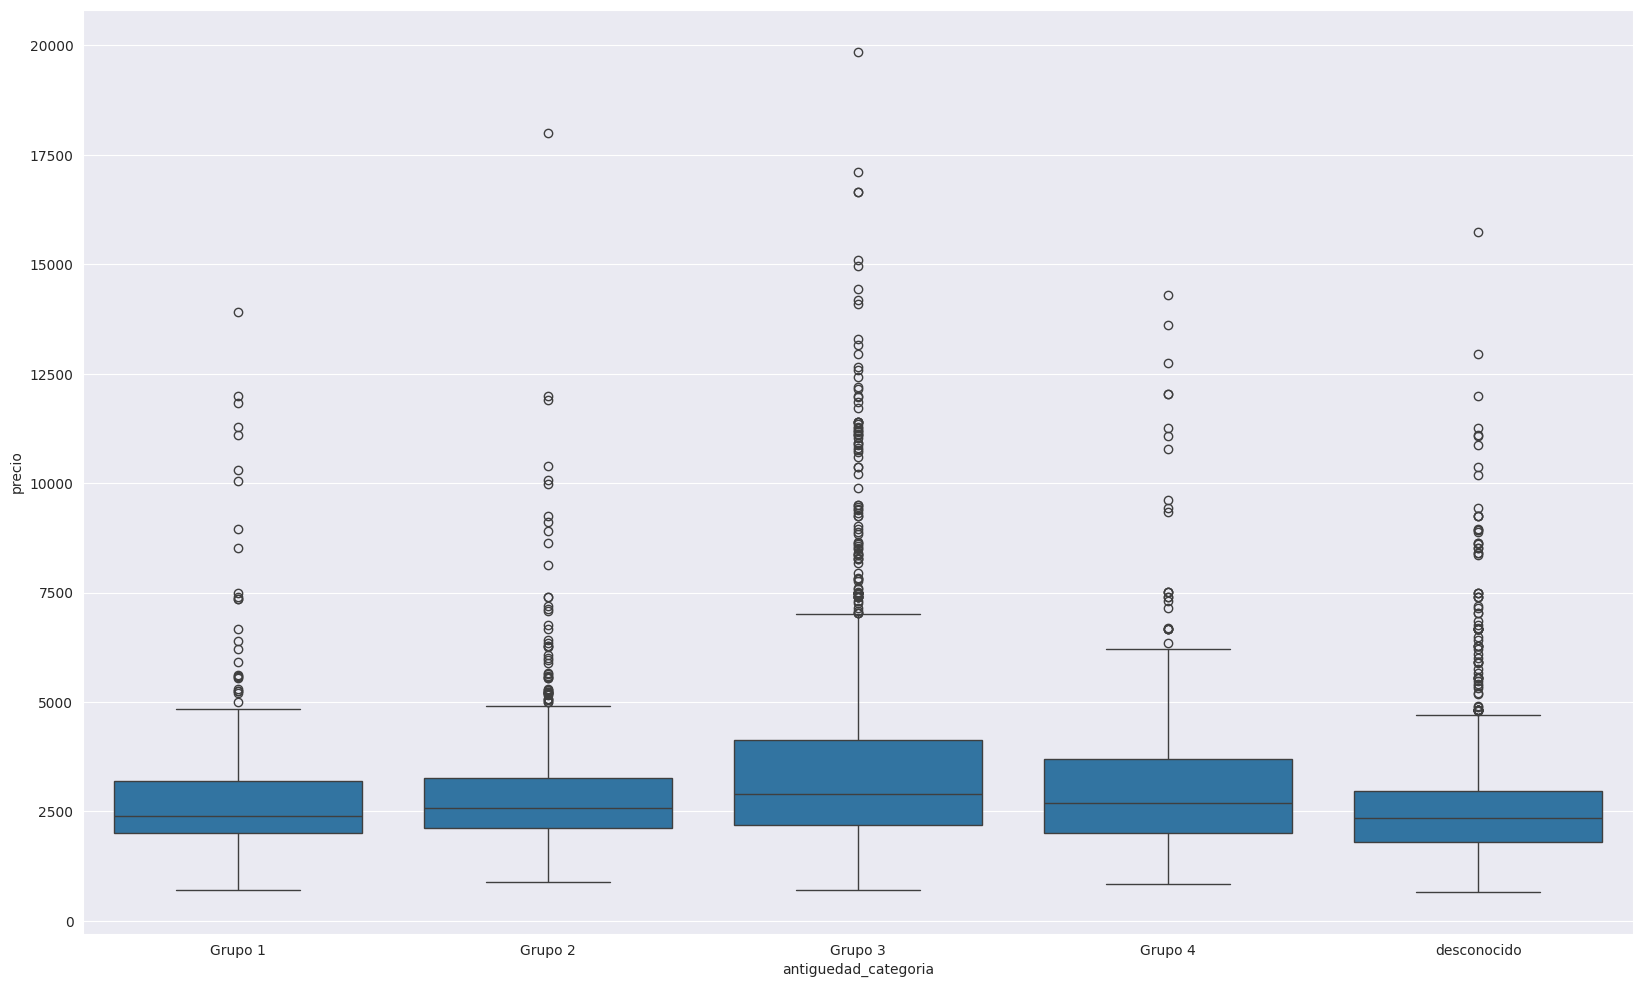

In [26]:
plt.figure(figsize=(20,12))
sns.boxplot(data=visualizacion_df,x='antiguedad_categoria',y='precio',order=antiguedad_ordenada)
plt.show()

Observaciones:

- Se puede apreciar una **tendencia ligeramente al alza**, es decir, a medida que aumenta la antiguedad el precio del departamento es ligeramente mayor o dicho de otro modo a departamentos más recientes el precio es menor. Se esperaría ver una disminución del precio si el departamento es más antiguo, sin embargo, se ve todo lo contrario, los departamentos' más antiguos tienen una media y una mediana superior a la de los departamentos más recientes.
- **Hipotesis : El precio de un departamento no varia considerablemente para departamentos recientes y antiguos**

**2.6 area vs antiguedad**

Relación entre la antiguedad y el área de un departamento. 

- Como afecta la antiguedad al área de un departamento?
- Los departamentos más recientes suelen tener menor area_

In [27]:
visualizacion_df.groupby('antiguedad_categoria')['area'].describe()

count        mean        std   min   25%   50%    75%  \
antiguedad_categoria                                                           
Grupo 1                440.0   70.771212  38.879230  28.0  45.0  60.5   79.0   
Grupo 2                531.0   79.476591  44.118222  26.0  50.0  70.0   90.0   
Grupo 3               1083.0  110.028493  69.192888  20.0  70.0  90.0  125.0   
Grupo 4                305.0  108.437613  65.532216  24.0  70.0  90.0  120.0   
desconocido            956.0   86.644912  49.960783  25.0  55.0  74.0  100.0   

                        max  
antiguedad_categoria         
Grupo 1               320.0  
Grupo 2               450.0  
Grupo 3               570.0  
Grupo 4               472.0  
desconocido           420.0

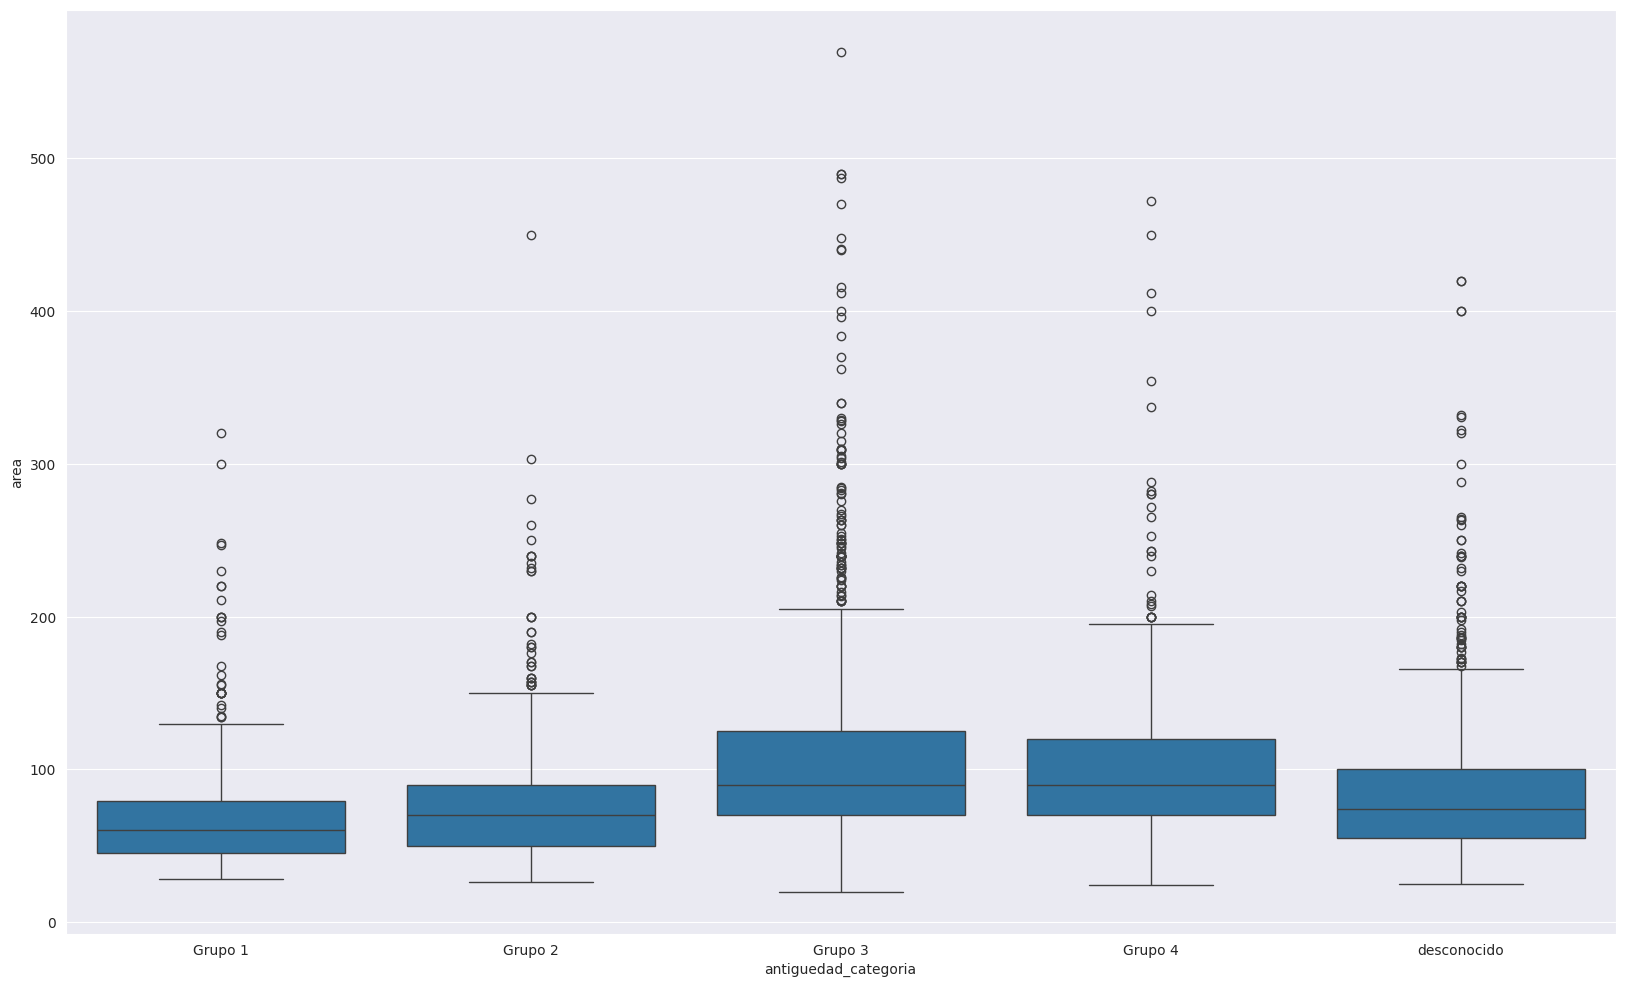

In [28]:
plt.figure(figsize=(20,12))
sns.boxplot(data=visualizacion_df,x='antiguedad_categoria',y='area',order=antiguedad_ordenada)
plt.show()

Observaciones:

- Se puede apreciar una **tendencia al alza**, es decir, a medida que aumente la antiguedad del departamento el área se hace más grande, o dicho de otro modo, los departamentos más antiguos solían tener mayor área, ádemas podemos agregar que el área ha ido disminuyendo aproximadamente en un 30% con el tiempo.
- **Hipotesis: Los departamentos más recientes poseen una menor área que los departamentos más antiguos.**

**2.7. Precioxm2 vs antiguedad**

Relación entre la antiguedad y el área de un departamento. 

- Como afecta la antiguedad al precio de cada m2 de un departamento?
- El precio de cada m2 es mayor para departamentos más recientes?


In [29]:
visualizacion_df.groupby('antiguedad_categoria')['precioxm2'].describe()

count       mean        std        min        25%  \
antiguedad_categoria                                                       
Grupo 1                440.0  41.757541  13.272532  13.500000  32.080729   
Grupo 2                531.0  39.919132  11.579821  12.500000  31.780710   
Grupo 3               1083.0  34.138871   9.669924  13.549090  27.402334   
Grupo 4                305.0  31.236034   9.048337  13.253012  24.666667   
desconocido            956.0  33.529236  10.867780  10.034347  25.887199   

                            50%        75%        max  
antiguedad_categoria                                   
Grupo 1               40.357257  51.111111  79.666667  
Grupo 2               38.888889  47.533784  78.048780  
Grupo 3               32.941176  39.509569  74.200000  
Grupo 4               30.136986  36.666667  61.666667  
desconocido           32.104762  40.139992  81.871560

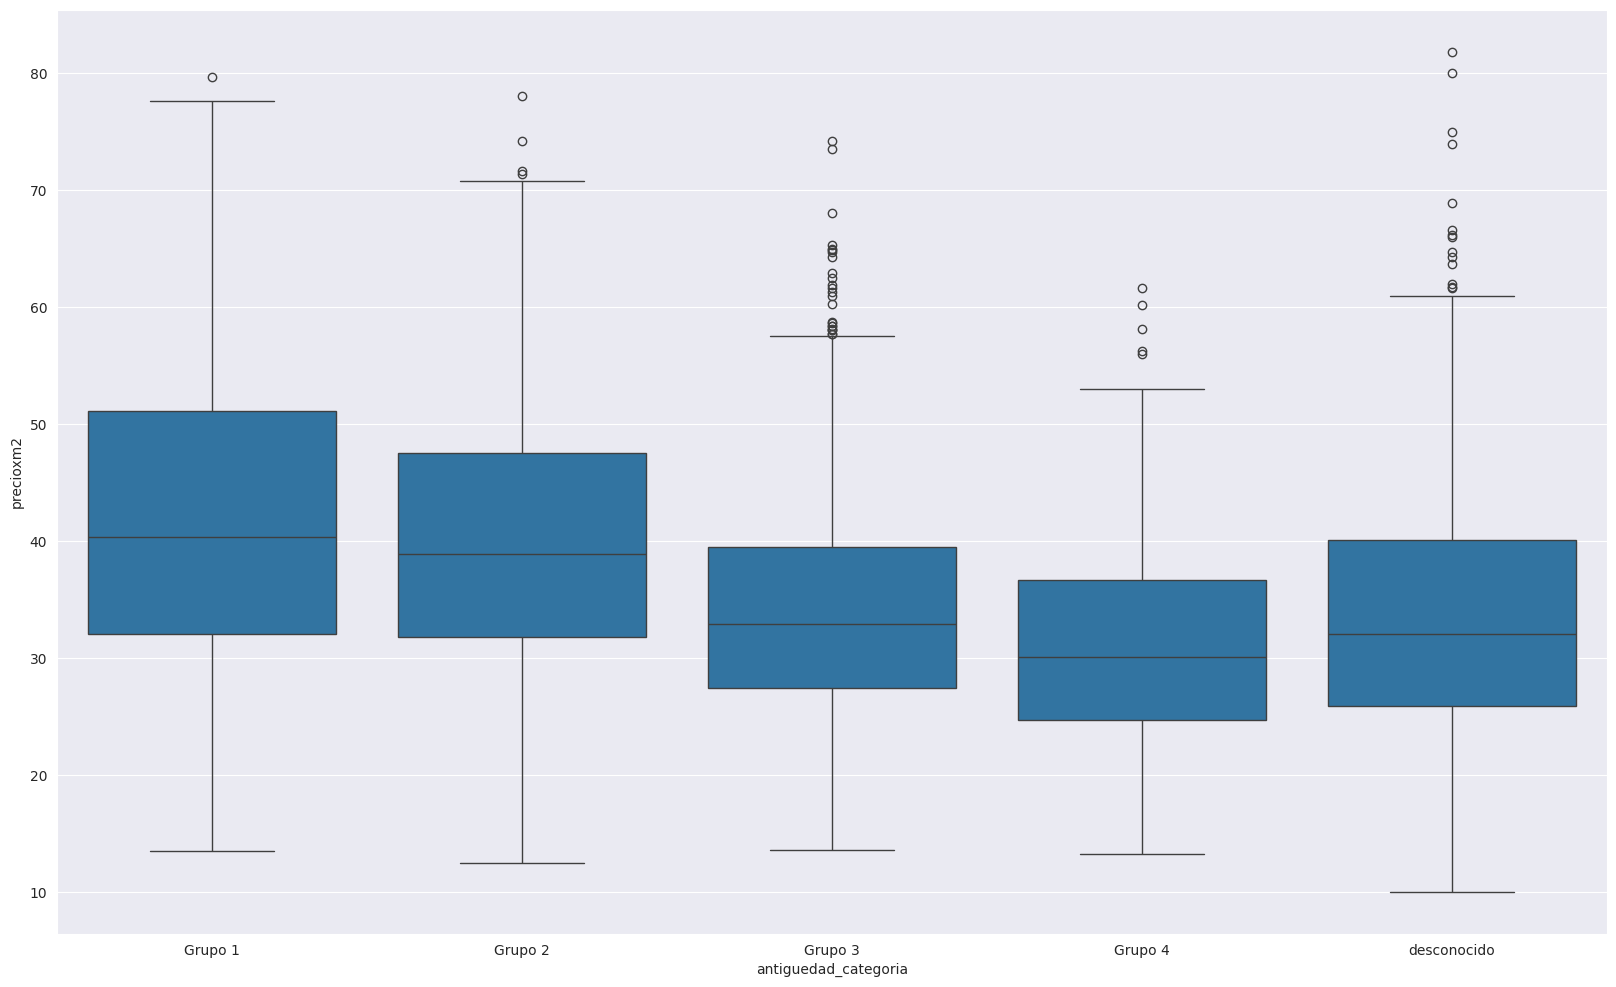

In [30]:
plt.figure(figsize=(20,12))
sns.boxplot(data=visualizacion_df,x='antiguedad_categoria',y='precioxm2',order=antiguedad_ordenada)
plt.show()


Observaciones:
- Se puede apreciar una **tendencia a la baja**, es decir, a medida que aumenta la antiguedad del departamento el precio de cada m2 tiende a ser menor o dicho de otro modo a departamentos más nuevos el precio de cada m2 es mayor.
- Se puede ver que antes cada m2 de un departamento costaba **S/32.5** en promedio y ahora cada m2 de un departamento cuesta **S/40**. 
- **Hipotesis: Los departamentos más recientes poseen un mayor precio por cada m2 que los antiguos.**

 **2.8. Precio vs Dormitorios, Precio vs baños**
 
Relación entre el número de dormitorios y el precio del departamento. 

- Como afecta el número de dormitorios o baños al precio de un departamento?
- A mayor cantidad de dormitorios y baños el precio de un departamento aumenta?
  
Para poder aislar y comprender el efecto real del número de dormitorios (o baños) sobre el precio, es fundamental controlar el área. Al analizar el precioxm2 se elimina la influencia directa del tamaño total del inmueble, permitiéndonos evaluar si, manteniendo constante el área, un mayor número de dormitorios (o baños) se asocia a diferencias en el precio. Esto nos ayuda a determinar si el mayor "aprovechamiento" del espacio, que puede implicar habitaciones más pequeñas o un diseño menos óptimo, se traduce en una reducción del precio por metro cuadrado, pese a que el precio total pueda ser mayor debido al mayor tamaño.


In [31]:
visualizacion_df.groupby(["distrito_clase","dormitorios"])['precioxm2'].describe()

count       mean        std        min        25%  \
distrito_clase dormitorios                                                      
clase1         1.0          417.0  48.884889  11.655984  17.695652  40.808824   
               2.0          393.0  41.215352   9.799063  20.000000  34.351145   
               3.0          344.0  37.159159   8.480215  13.781919  31.578947   
               4.0           36.0  33.958526   8.756316  11.861189  27.750000   
               5.0            2.0  31.669456   3.563049  29.150000  30.409728   
clase2         1.0          243.0  39.376713  11.111249  10.057047  30.739247   
               2.0          371.0  34.239570   8.658289  11.637524  27.841615   
               3.0          540.0  31.527912   7.219508  10.332653  27.472527   
               4.0           46.0  27.314130   6.673597  12.787569  22.733607   
               5.0            5.0  29.452771   6.474802  23.259184  26.600985   
clase3         1.0          212.0  36.015027  10.521986  13.846154  28.333333   
               2.0          305.0  28.259012   8.306818  10.034347  22.368421   
               3.0          375.0  26.393060   6.334590  12.587958  21.666667   
               4.0           22.0  24.118200   9.789364  13.253012  17.869048   
               5.0            4.0  22.523634   4.455221  16.250000  21.709559   

                                  50%        75%        max  
distrito_clase dormitorios                                   
clase1         1.0          48.133333  56.300000  81.871560  
               2.0          40.277778  46.250000  73.579545  
               3.0          36.568627  40.683486  75.200000  
               4.0          31.687184  39.199346  52.214815  
               5.0          31.669456  32.929184  34.188912  
clase2         1.0          39.205298  47.587067  61.666667  
               2.0          34.722222  40.000000  59.523810  
               3.0          31.051593  35.463231  64.870130  
               4.0          27.444056  31.690260  44.047619  
               5.0          26.600985  30.802703  40.000000  
clase3         1.0          35.263889  42.726481  66.034483  
               2.0          27.058824  33.648649  58.142857  
               3.0          26.562500  30.301579  51.388889  
               4.0          22.643705  27.220931  47.250000  
               5.0          23.529412  24.343487  26.785714

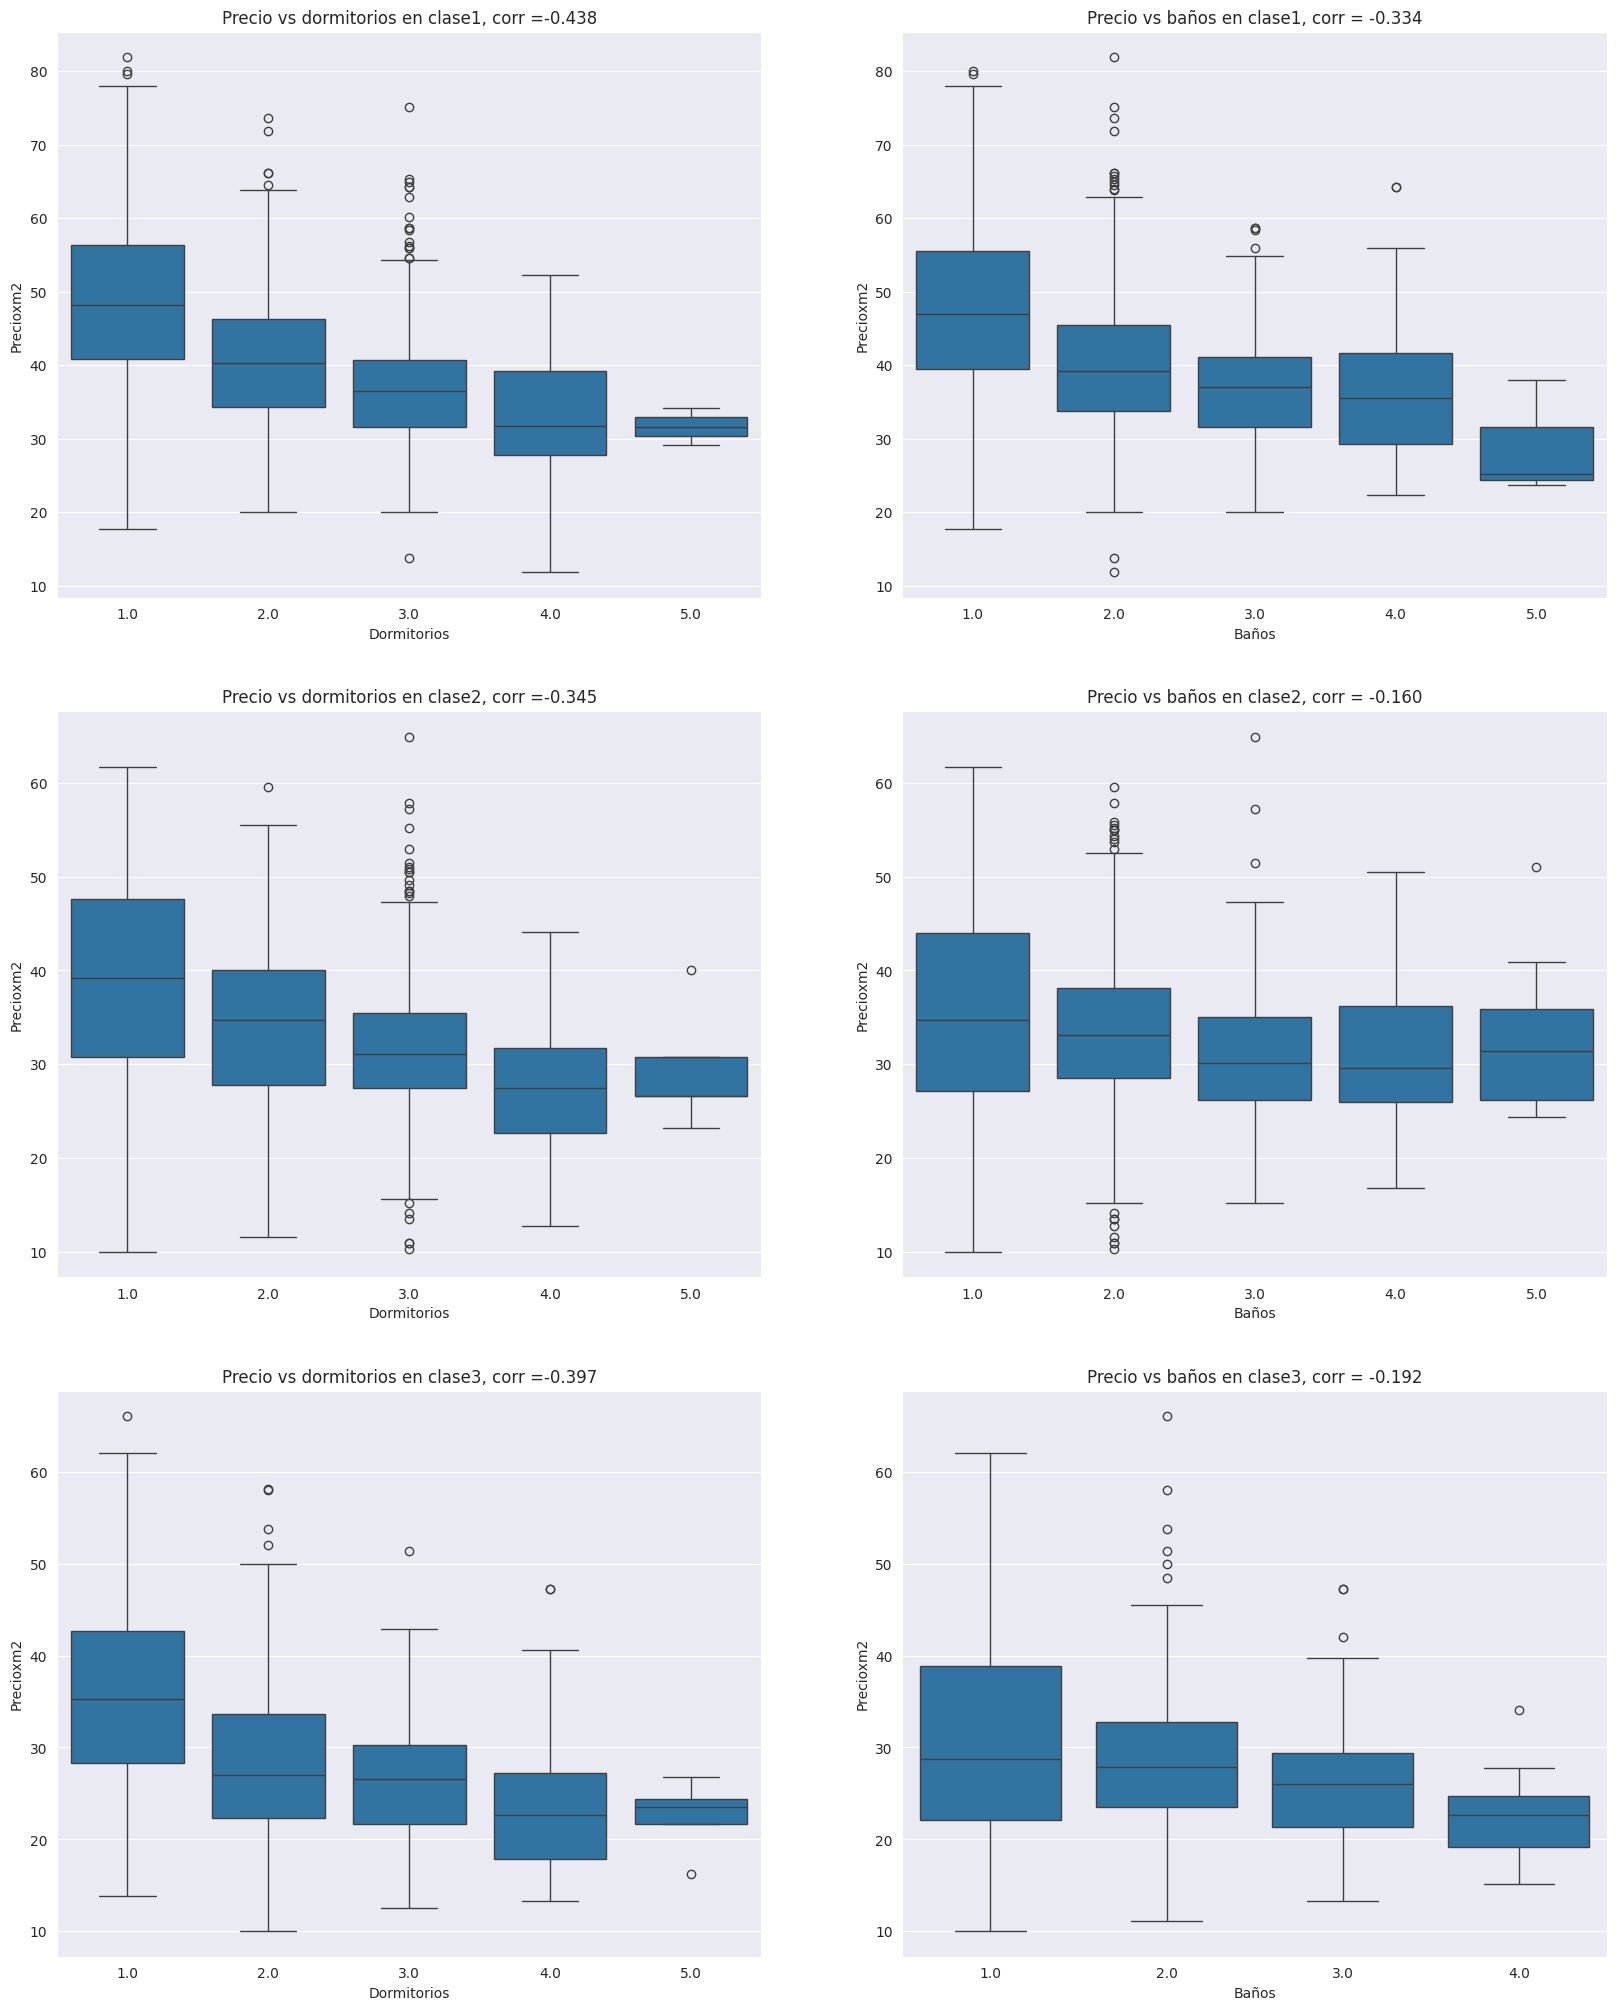

In [32]:
fig, ax = plt.subplots(3,2,figsize=(20,25))
for i,clase in enumerate(['clase1','clase2','clase3']):
    df_grupo = visualizacion_df[visualizacion_df['distrito_clase']==clase]
    
    corr = df_grupo[['precioxm2','dormitorios']].corr().values[0][1]
    sns.boxplot(data=df_grupo, x='dormitorios', y='precioxm2', ax=ax[i,0])
    ax[i,0].set_title(f'Precio vs dormitorios en {clase}, corr ={corr:.3f}')
    ax[i,0].set_xlabel('Dormitorios')
    ax[i,0].set_ylabel('Precioxm2')

    corr = df_grupo[['precioxm2','banos']].corr().values[0][1]
    sns.boxplot(data=df_grupo, x='banos', y='precioxm2', ax=ax[i,1])
    ax[i,1].set_title(f'Precio vs baños en {clase}, corr = {corr:.3f}')
    ax[i,1].set_xlabel('Baños')
    ax[i,1].set_ylabel('Precioxm2')

Observaciones:

- De la correlación analizada anteriormente habíamos visto que existe una correlación positiva entre el precio y el numero de dormitorios y el precio y el numero de baños, sin embargo, esto se puede deber a un efecto más que nada del área sobre el precio que de los dormitorios sobre el precio, ya que a mayor dormitorios mayor area y por ende mayor precio, sin embargo, cuando analizamos el precioxm2 (eliminando el factor area que influye directamente) podemos notar que existe una correlación negativa importante entre la cantidad de dormitorios  y baños sobre el precio, es decir, para 2 departamentos con igual area el departamento con más dormitorios (o con más baños) sera más económico, por ejemplo, para un departamento de **80m2**, en los distritos de **clase1**, el precioxm2 que sugiere la grafica es de aproximadamente **S/50** para **1 dormitorio**, esto implica que el precio del departamento sea de **S/4000**, ahora si buscamos un departamento con las mismas características y con 1 dormitorio más (**2 dormitorios**), la grafica sugiere que el precioxm2 promedio es de **S/40**, lo que implica que deberia costar **3200 soles** (más barato).
- Si bien es cierto acabamos de eliminar el factor area, que era determinante, aun existe el factor baños cuando analizamos dormitorios vs precio y el fator dormitorios cuando analizamos baños vs precio, por lo que para estar seguros del efecto que produce cada variable es necesario utilizar un modelo de regresión lineal múltiple que incluye a esas varaibles como predictores,para poder obtener el efecto "independiente" de cada uno sobre el precio.
- **Hipótesis: Para propiedades de igual área, un mayor número de dormitorios (o de baños) se asocia con un precio por metro cuadrado menor, lo que sugiere que, al controlar por el tamaño, la mayor compartimentación del espacio influye negativamente en el precio del inmueble.**

**2.9. antiguedad vs dormitorios+banos**

Relación entre el número de baños y el precio del departamento. 

- Como afecta la antiguedad al numero de dormitorios y baños de un departamento?
- Departamentos más antiguos poseen mayor número de dormitorios y baños?
 

In [33]:
visualizacion_df.groupby("antiguedad_categoria")['dorm+ban'].describe()

count      mean       std  min  25%  50%  75%  max
antiguedad_categoria                                                     
Grupo 1                440.0  3.506818  1.363350  2.0  2.0  4.0  5.0  8.0
Grupo 2                531.0  3.751412  1.417669  2.0  2.0  4.0  5.0  9.0
Grupo 3               1083.0  4.399815  1.550112  2.0  3.0  5.0  5.0  9.0
Grupo 4                305.0  4.206557  1.453203  2.0  3.0  4.0  5.0  8.0
desconocido            956.0  3.922594  1.492134  2.0  2.0  4.0  5.0  9.0

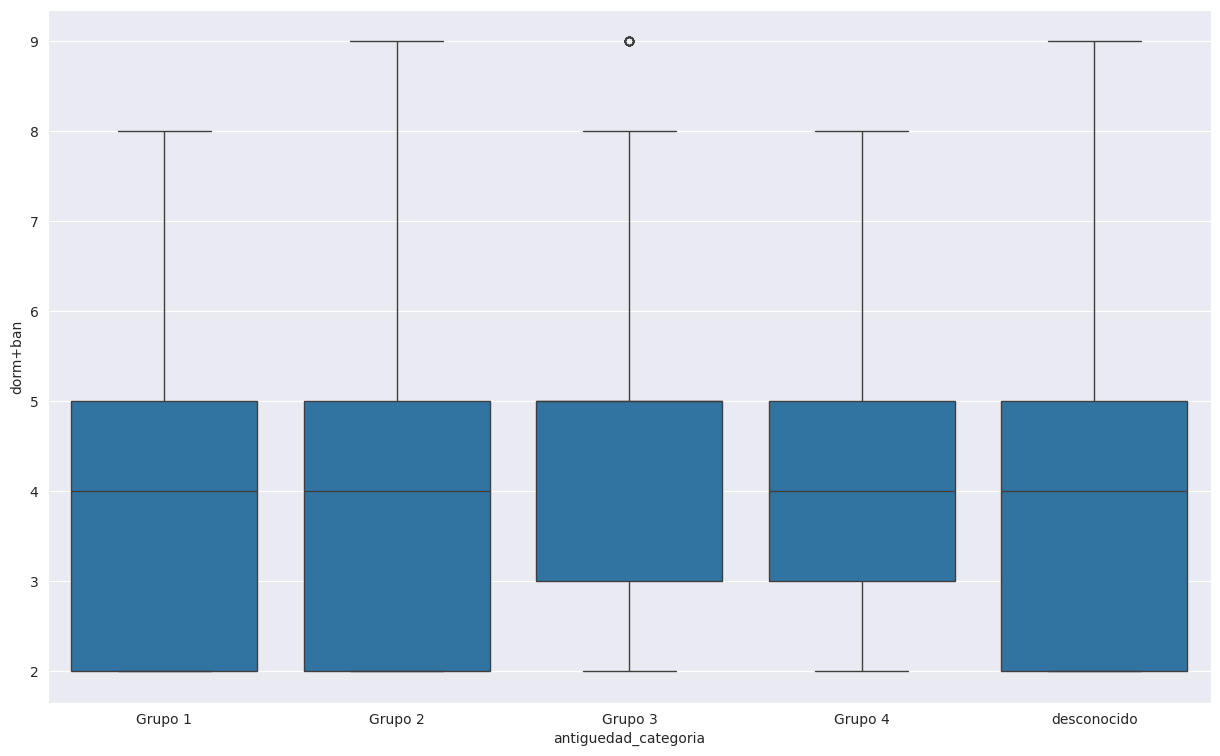

In [34]:
plt.figure(figsize=(15,9))
sns.boxplot(data=visualizacion_df,x='antiguedad_categoria',y='dorm+ban',order=antiguedad_ordenada)
plt.show()

Observaciones:

- Como se esperaba, a más baños el precio suele ser mayor, esto también se debe a que existe una mayor área cuando existe un número mayor de baños.
- Se puede ver ademas que existe un gran porcentaje de outliers superiores en el precio para departamentos con 2 baños.
- **Hipotesis: La distribucion de dormitorios y baños sigue siendo la misma en departamentos más recientes**

**2.10. antiguedad-distrito**

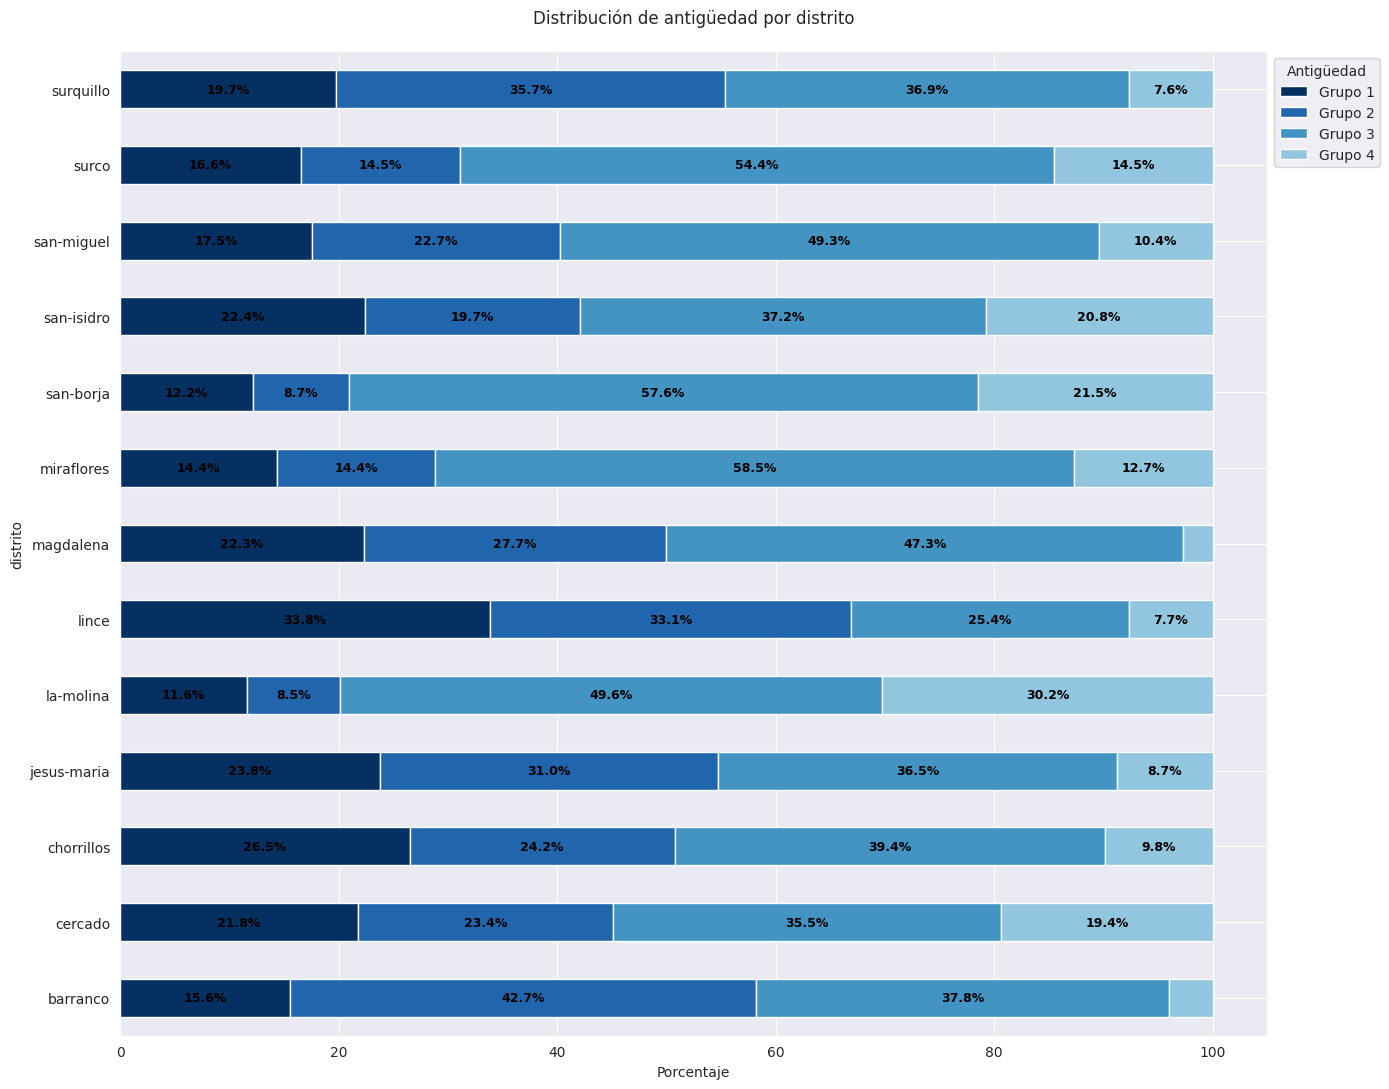

In [35]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

df_copia = visualizacion_df.copy()
df_copia['antiguedad_categoria'] = np.where(data['antiguedad_categoria']=='desconocido',np.nan,data['antiguedad_categoria'])

# Crear tabla de frecuencias
tabla_contingencia = pd.crosstab(df_copia['distrito'], df_copia['antiguedad_categoria'])

# Convertir a proporciones (%)
tabla_porcentajes = tabla_contingencia.div(tabla_contingencia.sum(axis=1), axis=0) * 100

# Definir colores neutros
colores_azules = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0']

# Graficar horizontalmente
fig, ax = plt.subplots(figsize=(14,11))  # Ajustamos el tamaño para adaptarse a barras horizontales
tabla_porcentajes.plot(kind='barh', stacked=True, ax=ax, color=colores_azules)

# Añadir porcentajes dentro de las barras (ajustado para orientación horizontal)
for i, barras in enumerate(ax.containers):
    for bar in barras:
        ancho = bar.get_width()
        if ancho > 5:  # Evitar etiquetas en porcentajes muy pequeños
            ax.text(bar.get_x() + ancho/2, bar.get_y() + bar.get_height()/2, f'{ancho:.1f}%',
                    ha='center', va='center', fontsize=9, color='black', fontweight='bold')

# Personalizar el gráfico
ax.set_xlabel('Porcentaje')  # Ahora el eje X representa el porcentaje
ax.set_title('Distribución de antigüedad por distrito', pad=20)
ax.legend(title='Antigüedad', bbox_to_anchor=(1, 1))

# Ajustar los márgenes para que quepa todo
plt.tight_layout()
plt.show()


**2.11. fecha_publicacion vs precio**

Relacion entre la fecha de publicacion y el precio

- Existen diferencias significativas entre el precio de departamentos en alquiler publicados este mes con los departamentos publicados meses anteriores? 


In [36]:
visualizacion_df.groupby("fecha_publicacion")['precio'].describe().T

fecha_publicacion             0             1
count               2498.000000    817.000000
mean                3215.280752   2959.588372
std                 2026.373891   2077.843708
min                  670.000000    700.000000
25%                 2050.000000   1900.000000
50%                 2600.000000   2437.000000
75%                 3600.000000   3150.000000
max                18000.000000  19855.000000

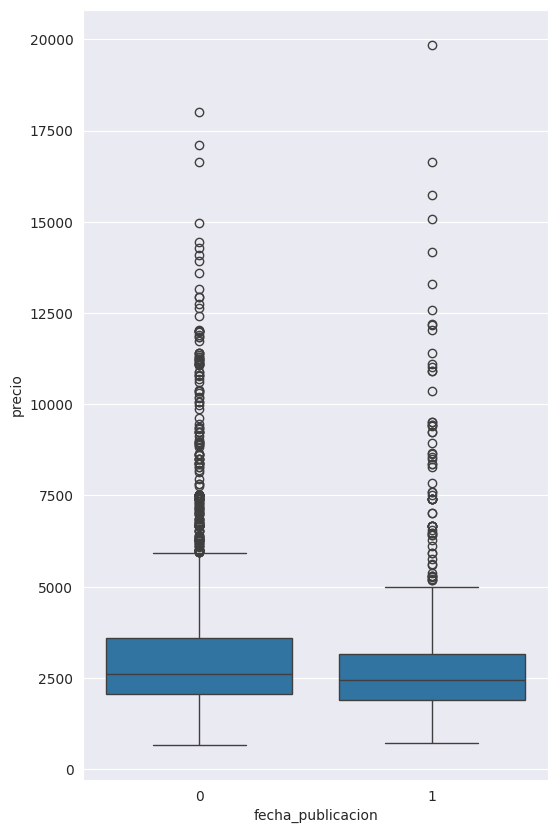

In [37]:
plt.figure(figsize=(6,10))
sns.boxplot(data=visualizacion_df,x='fecha_publicacion',y='precio')
plt.show()


Observaciones:

- Aparentemnente no existe una diferencia significativa tan grande con departamentos publicados este mes y los publicados meses anteriores, se puede ver que existe una diferencia promedio del 7%.
- **Hipostesis: Los departamentos publicados este mes no poseen precios diferentes a los precios del mes pasado**

**2.12. coordenadas vs distritos vs precioxm2**

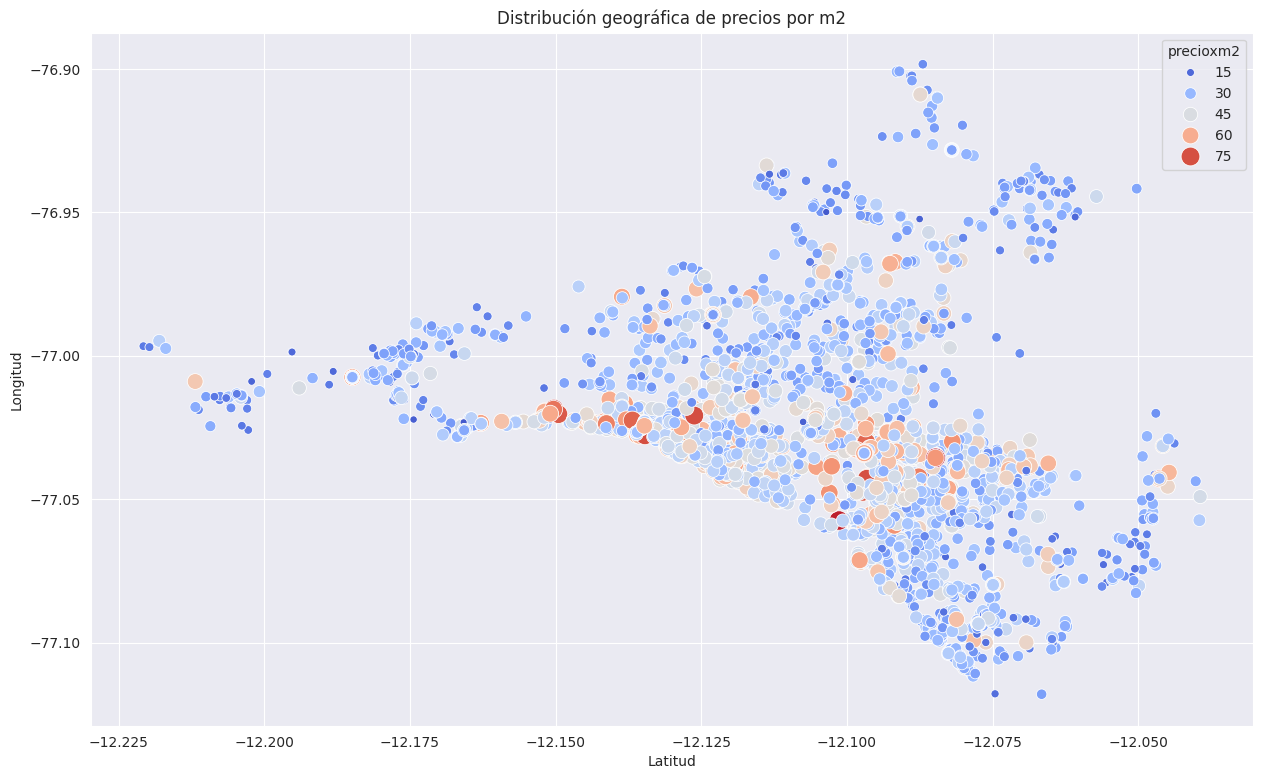

In [38]:
plt.figure(figsize=(15,9))
sns.scatterplot(data=visualizacion_df, x='latitud', y='longitud', size='precioxm2', sizes=(20, 200), hue='precioxm2', palette='coolwarm')
plt.title('Distribución geográfica de precios por m2')
plt.xlabel('Latitud')
plt.ylabel('Longitud')
plt.show()

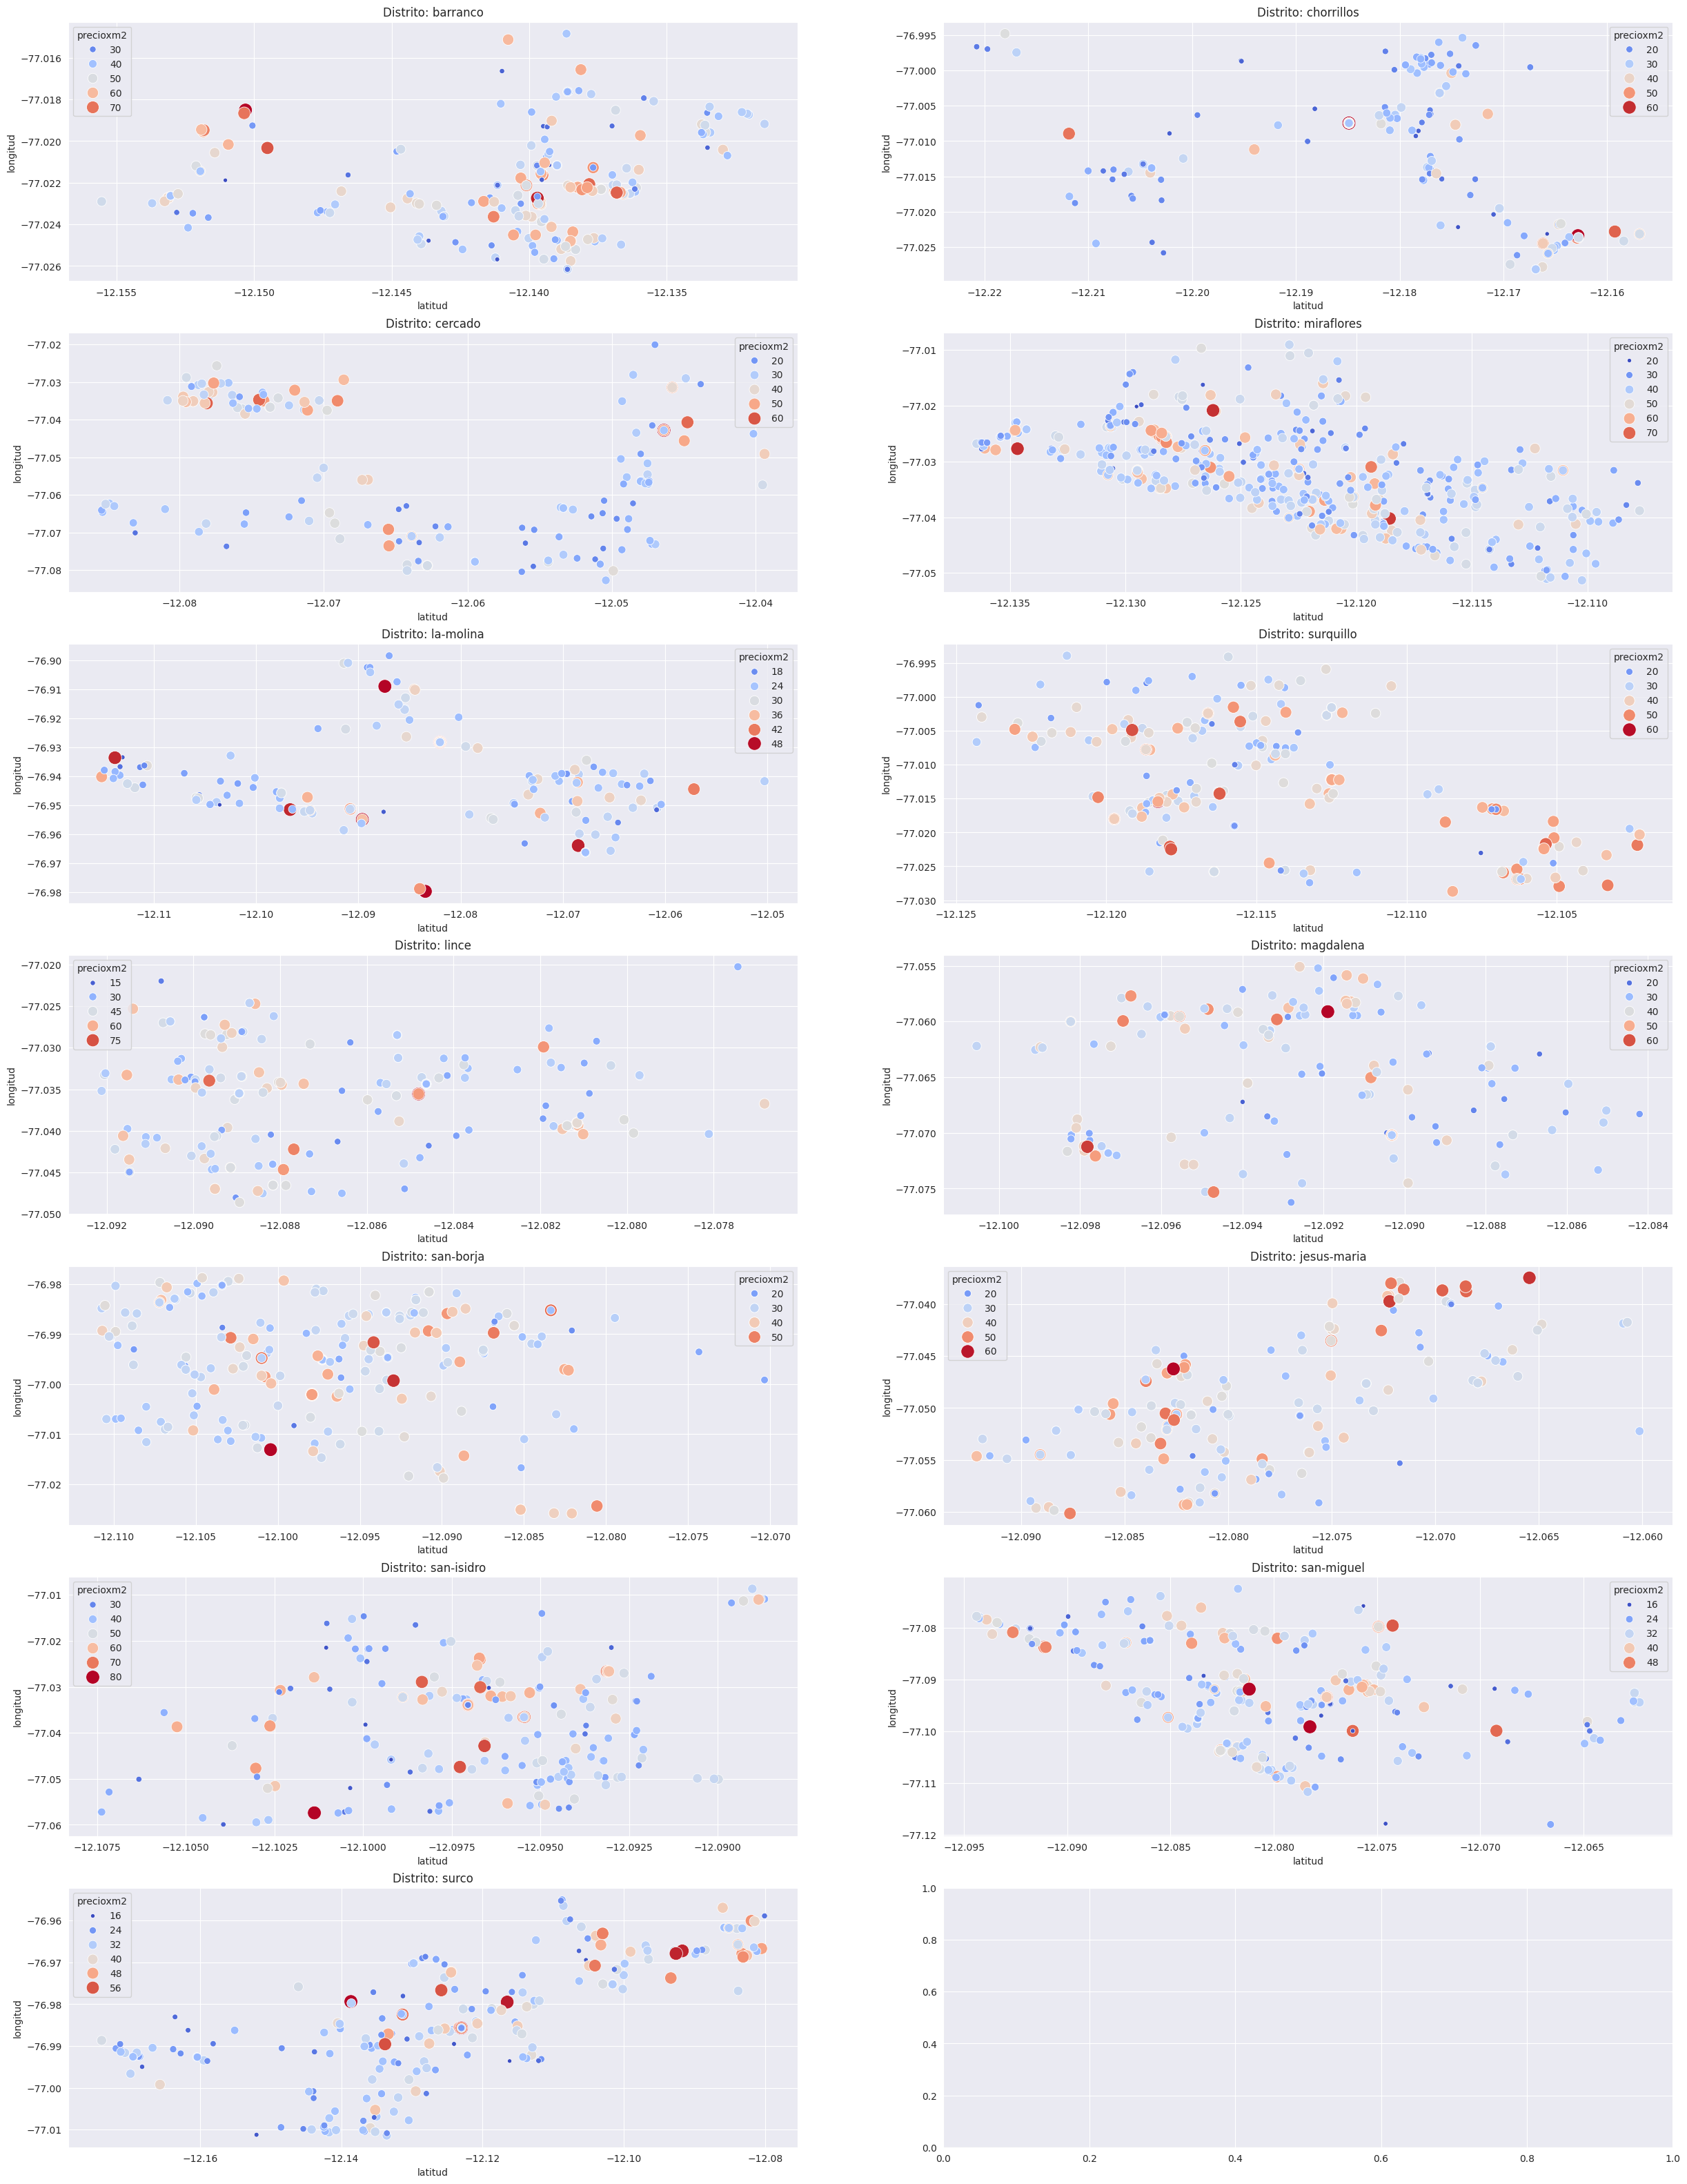

In [39]:
fig, ax = plt.subplots(7,2,figsize=(30,40))
for i,distrito in enumerate(visualizacion_df['distrito'].unique()):
    f,c = i//2,i%2
    sns.scatterplot(data=visualizacion_df.query(f"distrito=='{distrito}'"),
                    x='latitud',
                    y='longitud',
                    size='precioxm2',
                    sizes=(20, 200),
                    hue='precioxm2',
                    palette='coolwarm',
                    ax=ax[f,c]
                    )
    ax[f,c].set_title(f'Distrito: {distrito}')
fig.show()
                    

**2.13. distrito-dormitorios**

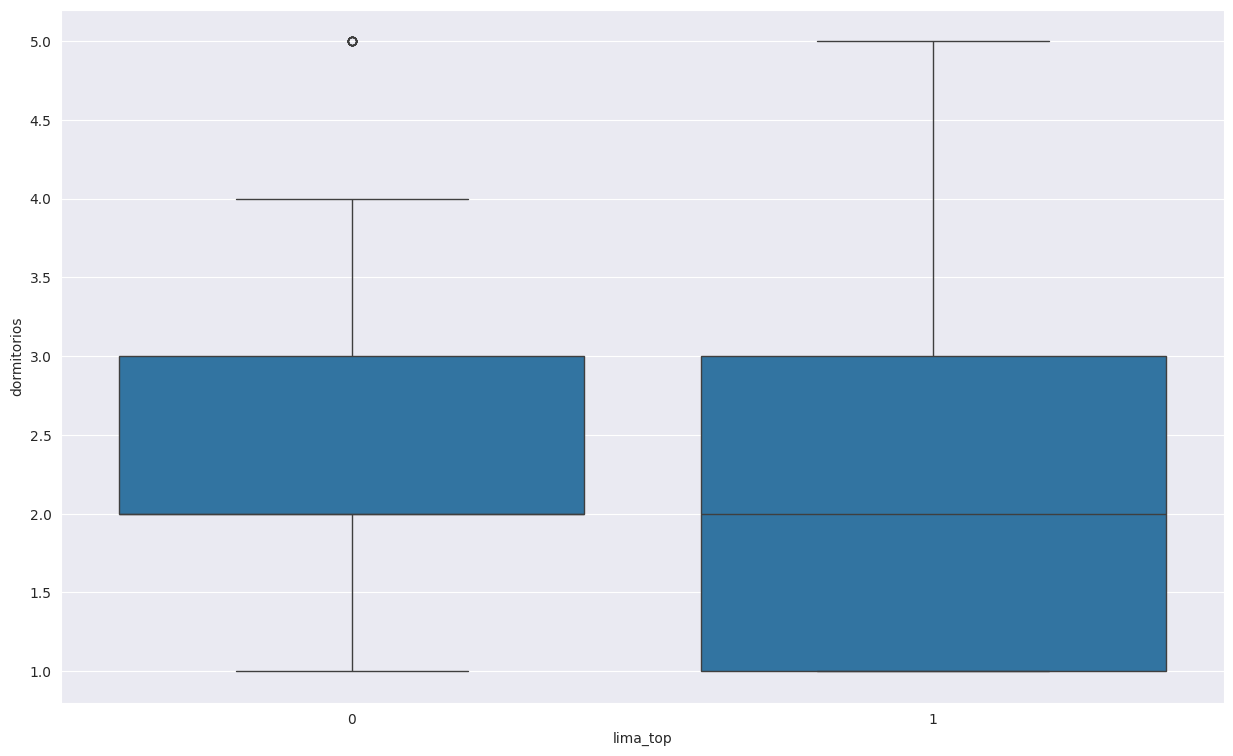

In [40]:
plt.figure(figsize=(15,9))
sns.boxplot(data=visualizacion_df,x='lima_top',y='dormitorios')
plt.show()

## 4. Planteamiento de hipotesis

In [41]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import kruskal
import scipy.stats as stats
from scipy.stats import spearmanr

In [42]:
hipotesis_df = data.copy()
hipotesis_df['lima_top'] = np.where(data['distrito'].isin(['barranco','san-isidro','miraflores','lince']),1,0)
hipotesis_df['precioxm2'] = data['precio']/data['area']
hipotesis_df['precioxm2_log'] = np.log(hipotesis_df['precioxm2'])
hipotesis_df['precio_log'] = np.log(hipotesis_df['precio'])
hipotesis_df['area_log'] = np.log(hipotesis_df['area'])
hipotesis_df['distrito_clase'] =  hipotesis_df['distrito'].map({
    "miraflores":"clase1",
    "san-isidro":"clase1",
    "barranco":"clase1",
    "lince":"clase1",
    "magdalena":"clase2",
    "surquillo":"clase2",
    "jesus-maria":"clase2",
    "san-borja":"clase2",
    "surco":"clase2",
    "cercado":"clase3",
    "san-miguel":"clase3",
    "chorrillos":"clase3",
    "la-molina":"clase3"
})



### Aseveracion 1: Existe una diferencia significativa entre el precio promedio de cada m2 en los distritos considerados de Lima-Top

Determinar si existen diferencias significativas en el precio por m2 entre los distritos clasificados como "Lima-Top" (Barranco, Miraflores, San Isidro) y Lince (potencial nuevo distrito top).

- Ho: μ_barranco = μ_miraflores = μ_san_isidro = μ_Lince
- Ha: Al menos un par de distritos tiene precios por m² significativamente diferentes.


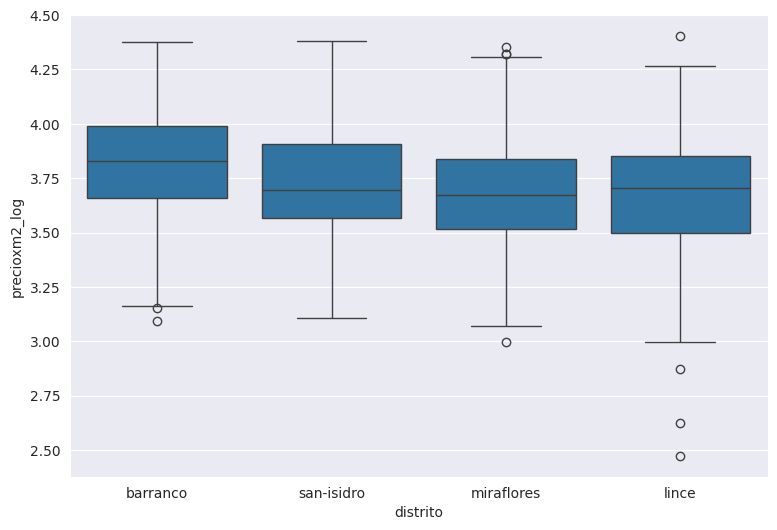

In [43]:
index = hipotesis_df.query("lima_top==1").groupby('distrito')['precioxm2_log'].mean().sort_values(ascending=False).index
plt.figure(figsize=(9,6))
sns.boxplot(data=hipotesis_df.query("lima_top==1"),x='distrito',y='precioxm2_log',order=index)
plt.show()

Podemos ver en el gráfico que Barranco tiene una mediana y una distribución notablemente más alta que la de los otros distritos.

Ademas podemos ver que el distrito de Lince tiene una mediana superior al de san isidro y miraflores, sin embargo, tiene outliers inferiores que podrían reducir su promedio y hacer que sea significativamente diferente a los distritos de San Isidro y Miraflores.

In [44]:
data_tukey = hipotesis_df[hipotesis_df['distrito'].isin(['miraflores', 'san-isidro', 'barranco','lince'])]

tukey_result = pairwise_tukeyhsd(endog=data_tukey['precioxm2_log'],
                                 groups=data_tukey['distrito'],
                                 alpha=0.05)

print(tukey_result)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
  barranco      lince  -0.1504    0.0 -0.2138  -0.087   True
  barranco miraflores   -0.127    0.0 -0.1814 -0.0726   True
  barranco san-isidro  -0.0878 0.0011 -0.1483 -0.0273   True
     lince miraflores   0.0234  0.689 -0.0313  0.0781  False
     lince san-isidro   0.0626 0.0404  0.0019  0.1233   True
miraflores san-isidro   0.0392 0.2015 -0.0121  0.0905  False
------------------------------------------------------------


Observaciones:
- Como podemos ver en el distrito de Barranco existe una diferencia significativa bastante importante con los otros distritos que hemos clasificado como Lima-Top, como se podía apreciar en la gráfica.
- Tambien podemos ver que Miraflores no presenta una diferencia significativa con los distritos de Lince y San Isidro apoyándonos en la hipótesis nula.
- Con respecto a la relación entre el distrito de Lince y San Isidro, podemos observar que en teoría si existe una diferencia significativa entre estos distritos, la media de San Isidro es ligeramente mayor a la media de Lince pero si consideramos que Lince posee outliers inferiores y estos sesgan al calculo de la media, agregamos ademas que la mediana de este distrito es ligeramente superior a la mediana de San Isidro, podemos decir que el p-valor igual a 0.04 < 0.05 no es tan concluyente, por lo que haremos una prueba de Kruskal-Wallis que compara la distribución de las medianas entre los grupos para estar mas seguros.

Conclusiones:

1. El distrito TOP1 con mayor precio por cada m2 es Barranco, con una diferencia notable.
2. Es necesario hacer otra prueba de hipótesis con los distritos de Miraflores, San Isidro y Lince, que compare las medianas en lugar de las medias.
3. Dado el p-valor extremadamente bajo en las comparaciones del distrito de Barranco, se descarta que esta diferencia sea producto del azar, reforzando la hipótesis de que el distrito de Barranco es el distrito con la renta más cara de Lima.

### Aseveracion2: No existe una diferencia significativa entre la mediana del precio del m2 entre San Isidro, Lince y Miraflores.

Determinar si existen diferencias significativas en el precio del m2 en los distritos de Miraflores, San Isidro y Lince, todos clasificados como "Lima-Top".

- **$H_0$**: $\tilde{X}_{\text{Miraflores}} = \tilde{X}_{\text{San Isidro}} = \tilde{X}_{\text{Lince}}$
- **$H_a$**: Al menos un par de distritos tiene precios por m² con medianas significativamente diferentes.


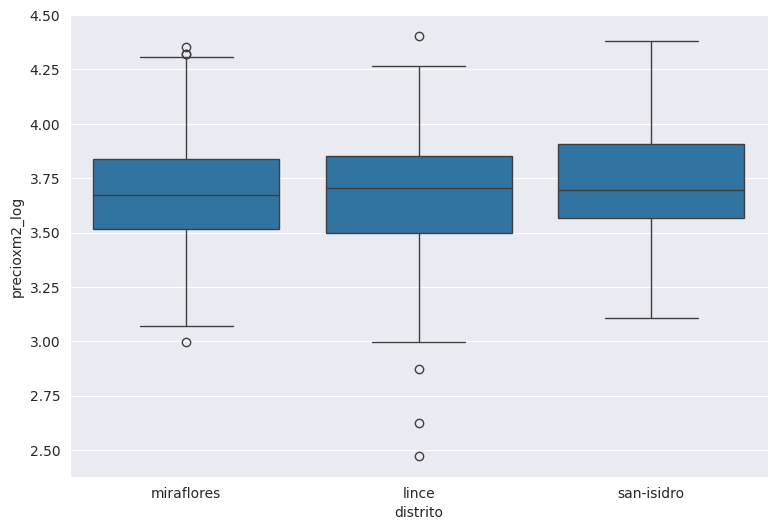

In [45]:
plt.figure(figsize=(9,6))
sns.boxplot(data=hipotesis_df.query("distrito.isin(['miraflores','lince','san-isidro'])"),
            x='distrito',y='precioxm2_log')
plt.show()

Como podemos ver en el gráfico, las medianas y distribuciones de los distritos son muy similares.

In [46]:
miraflores = hipotesis_df[hipotesis_df['distrito']=='miraflores']['precioxm2_log']
san_isidro = hipotesis_df[hipotesis_df['distrito']=='san-isidro']['precioxm2_log']
lince = hipotesis_df[hipotesis_df['distrito']=='lince']['precioxm2_log']

kruskal_result = kruskal(miraflores, san_isidro, lince)
print(f"Kruskal-Wallis H-statistic: {kruskal_result.statistic:.3f}")
print(f"Kruskal-Wallis p-value: {kruskal_result.pvalue:.3f}")

Kruskal-Wallis H-statistic: 4.292
Kruskal-Wallis p-value: 0.117


Observiaciones:
- Como podemos ver el p-valor de esta prueba de hipótesis nos da 0.117>0.05 indicando que las diferencias entre las medianas de estos distritos pueden provocarse por azar, es decir, no es tan **improbable** de que estos distritos tengan una ligera variación en el precio por metro cuadrado considerando la hipótesis nula como verdadera.
- Formalmente podemos decir que no hay evidencia estadística suficiente para afirmar que existan diferencias en las medianas del precio por metro cuadrado entre los distritos analizados, indicando de que las diferencias observadas podrian deberse al azar muestral.

Conclusiones:
1. La mediana del precio del metro cuadrado en los distritos de Miraflores, San Isidro y Lince no poseen una diferencia significativa.
2. La probabilidad de encontrar una diferencia entre las medianas que se dé a causa del azar teniendo en cuenta la hipótesis nula es del 11.7% lo cual es suficientemente probable.

### Aseveracion3 : El precio de cada m2 en los distritos de lima-top es en promedio un 30% más caro que en los distritos no lima-top.

El objetivo es poder determinar, como vimos en el EDA, si el precio de cada m2 en los distritos de lima-top son en promedio un 30% mas caros que en los distritos que no pertenecen al lima_top.

- Ho: $\mu_{\text{adjusted\_log\_top}} - \mu_{\text{log\_no\_top}} = 0$
- H1: $\mu_{\text{adjusted\_log\_top}} - \mu_{\text{log\_no\_top}} > 0$

Usaremos el logaritmo del precioxm2 para controlar los outliers superiores que afectan la media y varianza, ademas nos ayuda a que la distribución sea mas cercana a la normal

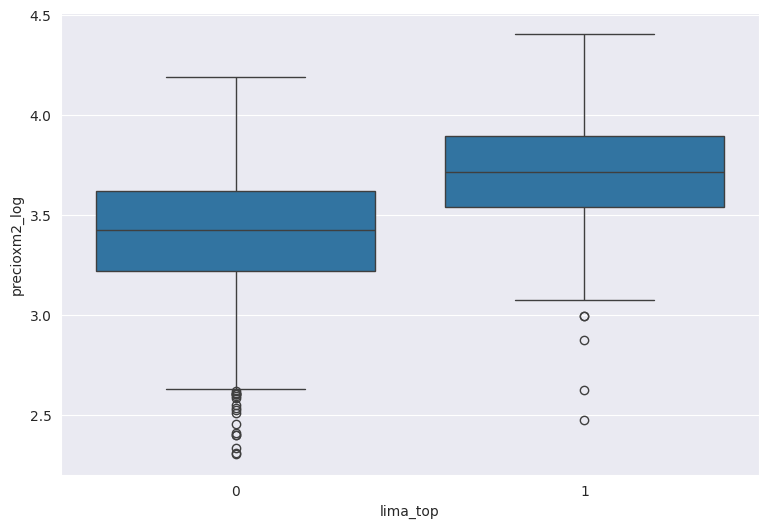

In [47]:
plt.figure(figsize=(9,6))
sns.boxplot(data=hipotesis_df,x='lima_top',y='precioxm2_log')
plt.show()

Como podemos ver en la grafica si existe una diferencia significativa notable entre los distritos de lima-top y no lima-top.

In [48]:

# Dividir los datos en grupos
log_top = hipotesis_df[hipotesis_df['lima_top'] == 1]['precioxm2_log']
log_no_top = hipotesis_df[hipotesis_df['lima_top'] == 0]['precioxm2_log']

# Transformar el grupo de lima_top restándole log(1.30)
adjusted_log_top = log_top - np.log(1.30)

# homocedasticidad
_, p_levene = stats.levene(log_top, log_no_top)
equal_var = p_levene > 0.05

stat, p_value = stats.ttest_ind(
    adjusted_log_top, log_no_top, equal_var=equal_var, alternative='greater'
)

diferencia = np.exp(log_top.mean()-log_no_top.mean())

print(f"Diferencia observada: {diferencia:.3f}")
print(f"Estadistico: {stat:.3f}")
print(f"t-test (alternativa 'greater'): p = {p_value:.5f}")

Diferencia observada: 1.349
Estadistico: 3.676
t-test (alternativa 'greater'): p = 0.00012


Observaciones:

-  La relación entre los precios por metro cuadrado en las zonas lima_top y no_top es 1.349, lo que indica que, en promedio, los precios en lima_top son aproximadamente 35% más altos que en lima no_top.
- El p-valor de 0.00012 es mucho menor que 0.05, lo que proporciona evidencia estadística fuerte para rechazar la hipótesis nula, por lo que hay suficiente evidencia para concluir que los precios de lima_top son significativamente mas altos que en no_top y que esta diferencia es al menos del 30%.

Conclusiones:
1. Los departamentos de lima_top son, en promedio, significativamente más caros por metro cuadrado que los de no_top, con una diferencia de al menos un 30%.
2. Dado el p-valor extremadamente bajo, se descarta que esta diferencia sea producto del azar, reforzando la hipótesis de que los precios en lima_top son consistentemente más altos.

### Aseveracion 4: Los departamentos mas antiguos tienen un precio promedio mayor a la de los mas recientes

El objetivo es evaluar si existe una correlación positiva entre la antigüedad de los departamentos y su precio, es decir, si los departamentos más antiguos tienden a ser mas caros.

- Ho: No existe una correlación significativa entre la antigüedad de los departamentos y su precio ($\rho = 0$).
- H1: Existe una correlación positiva significativa entre la antigüedad de los departamentos y su precio ($\rho > 0$).

Usaremos la prueba de hipótesis de spearman que es ideal para ver si existe una relación monótona, no necesariamente lineal.

In [49]:
# Asignar valores numéricos a los grupos (1 a 4)
hipotesis_df_copia = hipotesis_df.copy()
hipotesis_df_copia['antiguedad_ordinal'] = hipotesis_df_copia['antiguedad_categoria'].map({
    'Grupo 1': 1, 'Grupo 2': 2, 'Grupo 3': 3, 'Grupo 4': 4
})

# Eliminar filas con datos faltantes
hipotesis_df_copia.dropna(inplace=True)

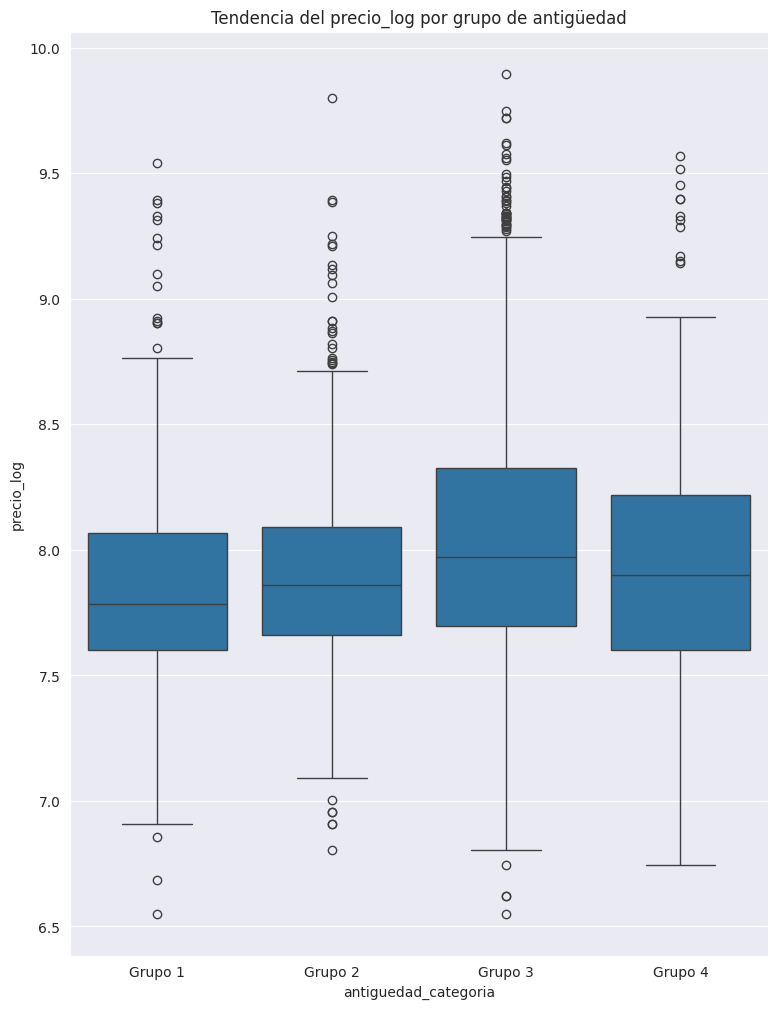

In [50]:
plt.figure(figsize=(9,12))
sns.boxplot(data=hipotesis_df, x='antiguedad_categoria', y='precio_log',order=[f'Grupo {i}' for i in range(1,5)])
plt.title("Tendencia del precio_log por grupo de antigüedad")
plt.show()

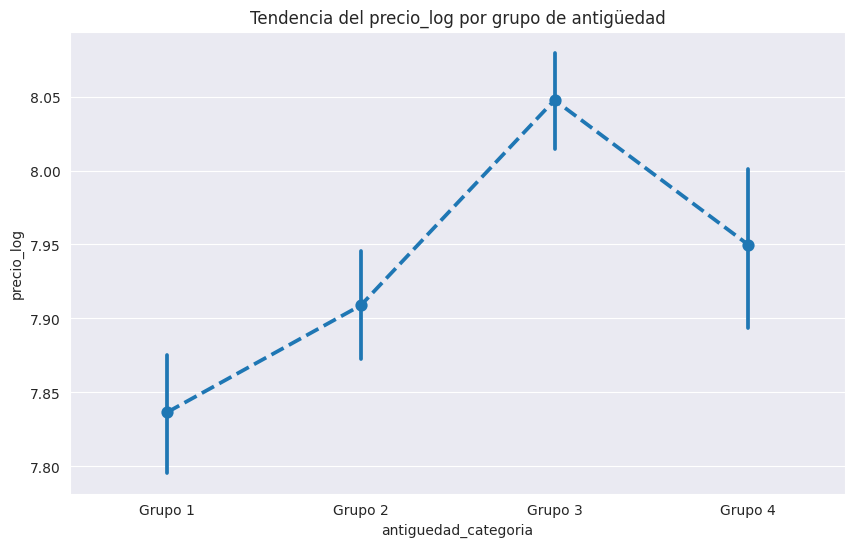

In [51]:
plt.figure(figsize=(10,6))
sns.pointplot(data=hipotesis_df,x='antiguedad_categoria',y='precio_log',order=[f'Grupo {i}' for i in range(1,5)],linestyle='--',)
plt.title("Tendencia del precio_log por grupo de antigüedad")
plt.show()

In [52]:
# Calcular correlación de Spearman (test bilateral por defecto)
rho, p_bilateral = spearmanr(hipotesis_df_copia['antiguedad_ordinal'], hipotesis_df_copia['precio_log'])

# Convertir a test unilateral (H₁: correlación positiva)
p_unilateral = p_bilateral / 2 if rho > 0 else 1 - p_bilateral / 2

print(f"Spearman's rho: {rho:.3f}")
print(f"p-valor (unilateral): {p_unilateral:.5f}")

Spearman's rho: 0.122
p-valor (unilateral): 0.00000


Observaciones:

- El coeficiente de correlación de Spearman ($\rho = 0.122$) indica una ligera correlación positiva entre la antigüedad y el precio de los departamentos.
- El p-valor extremadamente bajo (p < 0.00001) sugiere que esta correlación es estadísticamente significativa, permitiendo rechazar la hipótesis nula.

Conclusiones:

1. Existe una ligera correlación positiva entre la antigüedad de los departamentos y su precio, lo que indica que los departamentos más antiguos tienden a tener un precio ligeramente mayor.
2. Esta tendencia puede deberse a que los departamentos antiguos tenían propiedades como mayor área, mayor número de dormitorios, mayor número de baños, etc. A diferencia de los departamentos de hoy en dia que tienen una pequeña área, limitados dormitorios y baños, etc.

### Aseveración 5: Los departamentos mas antiguos tienen un area promedio mayor a la de los mas recientes

El objetivo es evaluar si existe una correlación positiva entre la antigüedad de los departamentos y su área promedio, es decir, si los departamentos más antiguos tienden a tener una mayor superficie.

- Ho: No existe una correlación significativa entre la antigüedad de los departamentos y su área ($\rho = 0$).
- H1: Existe una correlación positiva significativa entre la antigüedad de los departamentos y su área ($\rho > 0$).

Usaremos la prueba de hipótesis de spearman que es ideal para ver si existe una relación monótona, no necesariamente lineal.

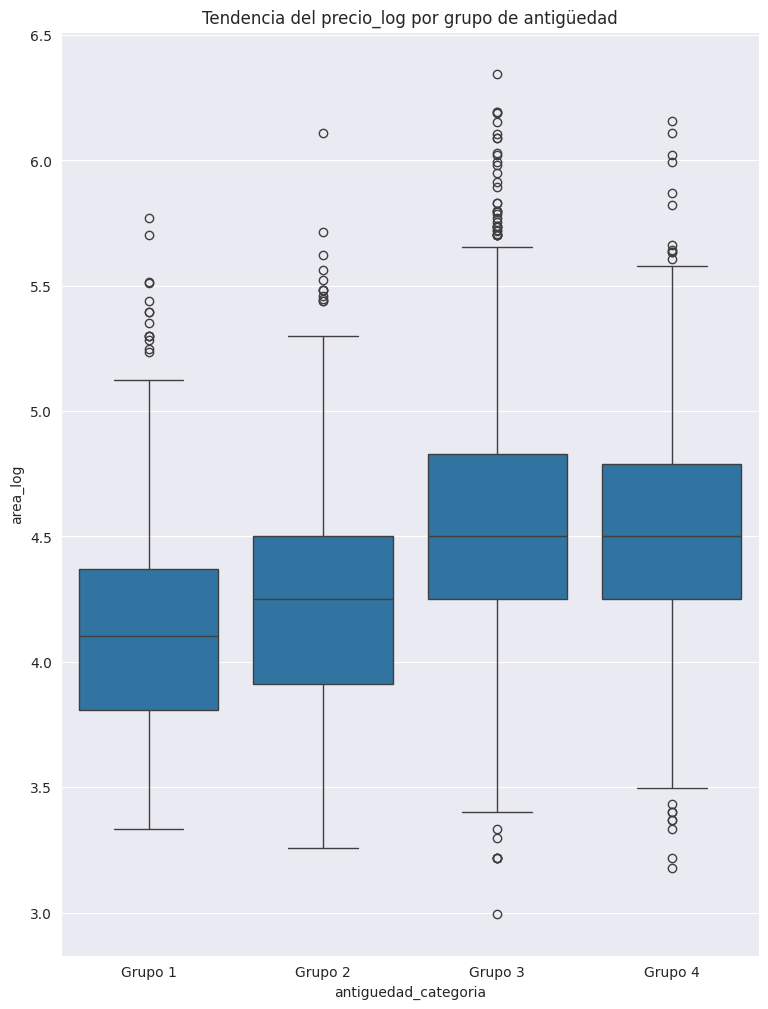

In [53]:
plt.figure(figsize=(9,12))
sns.boxplot(data=hipotesis_df, x='antiguedad_categoria', y='area_log',order=[f'Grupo {i}' for i in range(1,5)])
plt.title("Tendencia del precio_log por grupo de antigüedad")
plt.show()

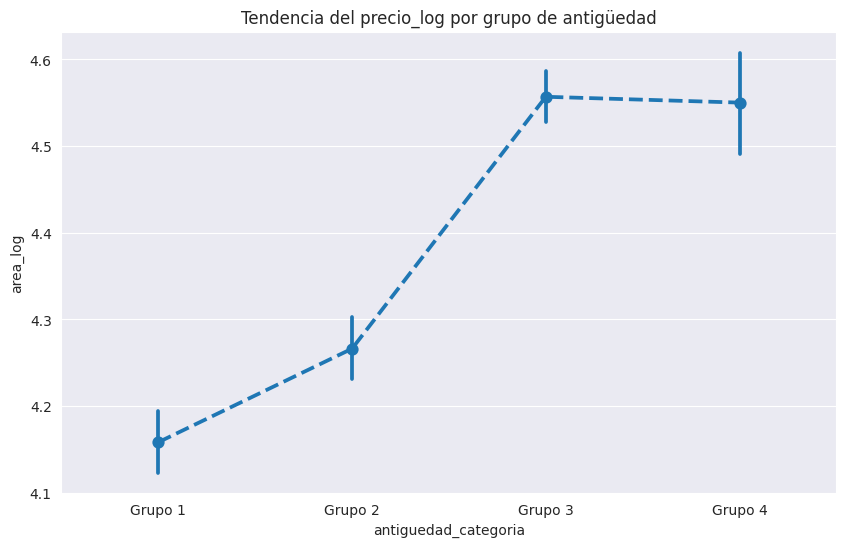

In [54]:
plt.figure(figsize=(10,6))
sns.pointplot(data=hipotesis_df,x='antiguedad_categoria',y='area_log',order=[f'Grupo {i}' for i in range(1,5)],linestyle='--',)
plt.title("Tendencia del precio_log por grupo de antigüedad")
plt.show()

In [55]:
# Calcular correlación de Spearman (test bilateral por defecto)
rho, p_bilateral = spearmanr(hipotesis_df_copia['antiguedad_ordinal'], hipotesis_df_copia['area_log'])

# Convertir a test unilateral (H₁: correlación positiva)
p_unilateral = p_bilateral / 2 if rho > 0 else 1 - p_bilateral / 2

print(f"Spearman's rho: {rho:.3f}")
print(f"p-valor (unilateral): {p_unilateral:.5f}")

Spearman's rho: 0.340
p-valor (unilateral): 0.00000


Observaciones:

- El coeficiente de correlación de Spearman ($\rho = 0.340$) indica una correlación positiva moderada entre la antigüedad y el área de los departamentos.
- El p-valor extremadamente bajo (p < 0.00001) sugiere que esta correlación es estadísticamente significativa, permitiendo rechazar la hipótesis nula.

Conclusiones:

1. Existe una correlación positiva y significativa entre la antigüedad de los departamentos y su área, lo que indica que los departamentos más antiguos tienden a tener una mayor superficie promedio.
2. Esta tendencia puede deberse a que cada vez Lima esta más saturada, existiendo una escasez y precio por metro cuadrado bastante algo en los departamentos lo que obliga a reducir el área de estos haciéndolos más asequibles, a diferencia de hace algunos años donde se preferian espacios más amplios.

### Aseveración 6: Los departamentos más antiguos tienen un precio por metro cuadrado mayor al de los más recientes

El objetivo es determinar si existe una correlación negativa entre la antigüedad de los departamentos y su precio por metro cuadrado, es decir, si los departamentos más antiguos tienden a tener un menor precio por m².

- Ho: No existe una correlación significativa entre la antigüedad de los departamentos y su precio por metro cuadrado ($\rho = 0$).
- H1: Existe una correlación negativa significativa entre la antigüedad de los departamentos y su precio por metro cuadrado ($\rho < 0$).

Usaremos la prueba de hipótesis de spearman que es ideal para ver si existe una relación monótona, no necesariamente lineal.

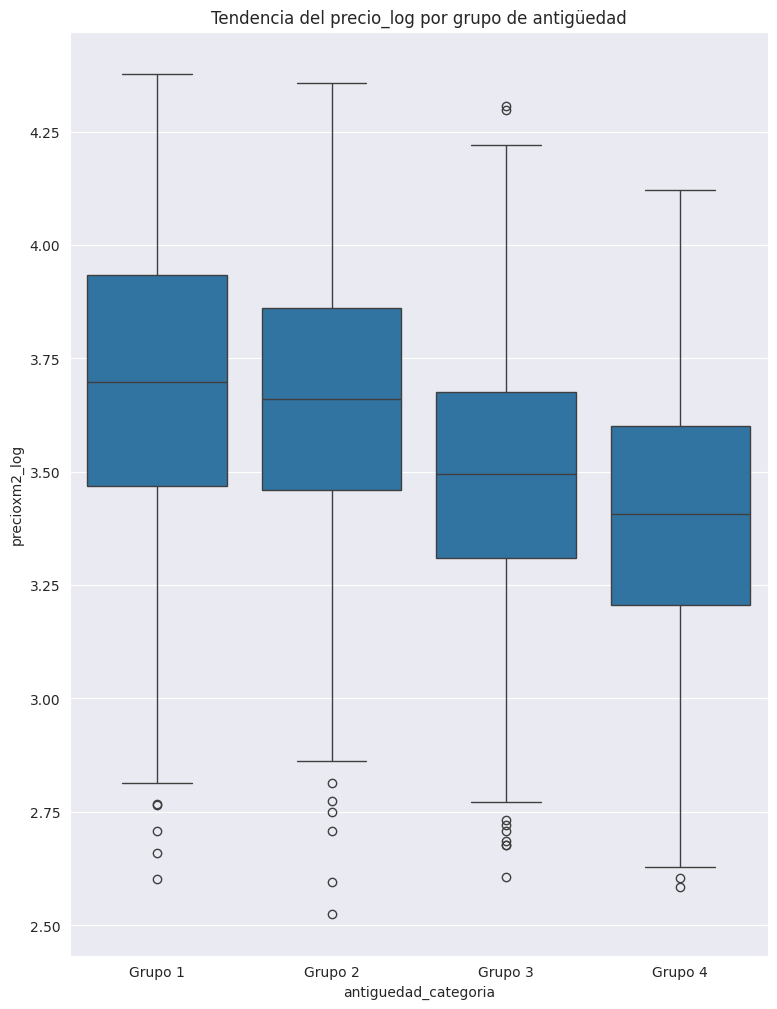

In [56]:
plt.figure(figsize=(9,12))
sns.boxplot(data=hipotesis_df, x='antiguedad_categoria', y='precioxm2_log',order=[f'Grupo {i}' for i in range(1,5)])
plt.title("Tendencia del precio_log por grupo de antigüedad")
plt.show()

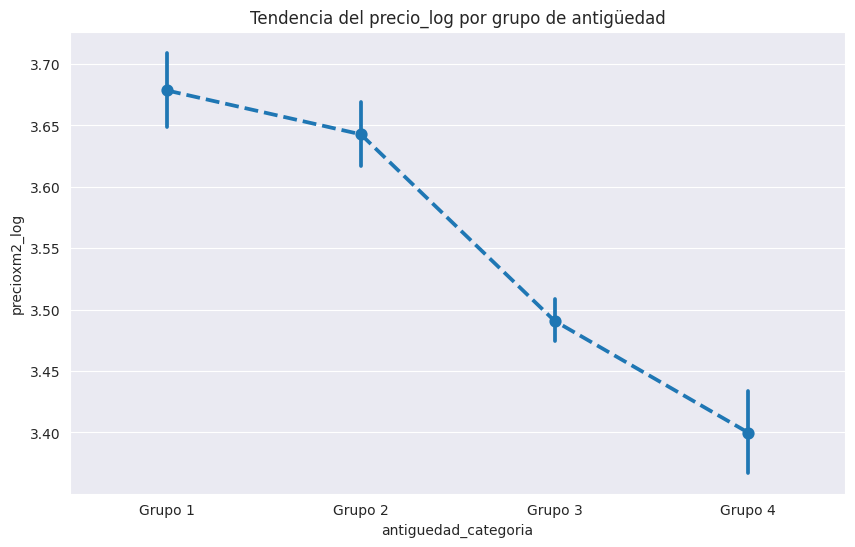

In [57]:
plt.figure(figsize=(10,6))
sns.pointplot(data=hipotesis_df,x='antiguedad_categoria',y='precioxm2_log',order=[f'Grupo {i}' for i in range(1,5)],linestyle='--',)
plt.title("Tendencia del precio_log por grupo de antigüedad")
plt.show()

In [58]:
# Eliminar filas con datos faltantes
hipotesis_df_copia.dropna(inplace=True)

# Calcular la correlación de Spearman (por defecto, el test es bilateral)
rho, p_bilateral = spearmanr(hipotesis_df_copia['antiguedad_ordinal'], hipotesis_df_copia['precioxm2_log'])

# Convertir el p-valor a test unilateral (hipótesis alternativa: correlación positiva)
p_unilateral = p_bilateral / 2 if rho < 0 else 1.0

print(f"Spearman's rho: {rho:.3f}")
print(f"p-valor (unilateral): {p_unilateral:.5f}")


Spearman's rho: -0.310
p-valor (unilateral): 0.00000


Observaciones:

- La correlación significativa respalda que existe una relación positiva entre la antigüedad y el precio por m².

Conclusiones:

- Existe evidencia estadística que indica que, controlando por la influencia de outliers mediante la transformación logarítmica, los departamentos más antiguos tienen un precio por metro cuadrado mayor, la correlación es bastante importante del -0.310.
- Esto puede deberse a diversos factores, pero el más lógico es que un departamento más antiguo necesitara más gastos de reparación y remodelación, lo que va a disminuir su valor en el mercado, ademas como vimos anteriormente el área de los departamentos antiguos suele ser mayor lo que inherentemente disminuye el precioxm2. 

### Aseveracion 7:  Los departamentos más antiguos tenian mas dormitorios y baños que los recientes.

El objetivo es determinar si existe una correlación positiva entre la antigüedad de los departamentos y el numero de dormitorios + el numero de baños, es decir, si los departamentos más antiguos tienden a tener más baños y dormitorios.

- Ho: No existe una correlación significativa entre la antigüedad de los departamentos y el número de dormitorios + el número de baños ($\rho = 0$).
- H1: Existe una correlación positiva significativa entre la antigüedad de los departamentos y el número de dormitorios + el número de baños ($\rho > 0$).

Usaremos la prueba de hipótesis de spearman que es ideal para ver si existe una relación monótona, no necesariamente lineal.

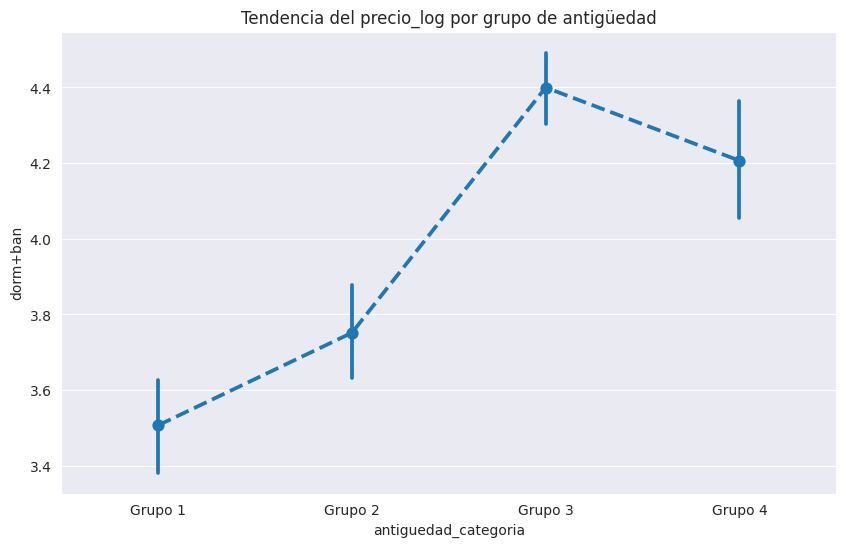

In [59]:
hipotesis_df_copia['dorm+ban'] = hipotesis_df['dormitorios']+hipotesis_df['banos']
plt.figure(figsize=(10,6))
sns.pointplot(data=hipotesis_df_copia,x='antiguedad_categoria',y='dorm+ban',order=[f'Grupo {i}' for i in range(1,5)],linestyle='--',)
plt.title("Tendencia del precio_log por grupo de antigüedad")
plt.show()

In [60]:
# Calcular correlación de Spearman (test bilateral por defecto)
rho, p_bilateral = spearmanr(hipotesis_df_copia['antiguedad_ordinal'], hipotesis_df_copia['dorm+ban'])

# Convertir a test unilateral (H₁: correlación positiva)
p_unilateral = p_bilateral / 2 if rho > 0 else 1 - p_bilateral / 2

print(f"Spearman's rho: {rho:.3f}")
print(f"p-valor (unilateral): {p_unilateral:.5f}")

Spearman's rho: 0.212
p-valor (unilateral): 0.00000


Observaciones:

- La correlación significativa respalda que existe una relación positiva entre la antigüedad y el número de baños y dormitorios.

Conclusiones:

- Existe evidencia estadistica que nos indica que los departamentos más antiguos tienen más dormitorios y baños.

### Aseveracion 8: La distribución interna de los departamentos (dormitorios y baños) influye significativamente en el precio, controlando el área.

El objetivo es determinar si, una vez controlado por el área, la configuración interna (número de dormitorios y de baños) tiene un efecto significativo en el precio de los departamentos.

- Ho: Los coeficientes de "dormitorios" y "baños" son cero cuando se controla por el área, es decir, la configuración interna no influye significativamente en el precio. (H0​:βdormitorios​=0 y βbanos​=0)
- H1: Al menos uno de los coeficientes (de "dormitorios" o "baños") es distinto de cero, lo que indica que la configuración interna tiene un efecto significativo en el precio, controlando por el área.

Utilizaremos un modelo de regresión lineal múltiple con “dormitorios”, “área” y “baños” como predictores del precio.  

In [61]:
import pandas as pd
import statsmodels.api as sm

def verificar_hipotesis_lineal(df, columnas_predictoras, columna_objetivo='precio'):
    try:
        # Datos
        X = df[columnas_predictoras]
        X = sm.add_constant(X)  # Agregar constante para la intersección
        y = df[columna_objetivo]

        # Modelo de regresión
        model = sm.OLS(y, X).fit()

        # Extraer resultados clave
        resultados = {'Intercepto': model.params['const'], 'R2': model.rsquared,
                      'R2_Ajustado': model.rsquared_adj, 'Observaciones': len(df)}

        for col in columnas_predictoras:
            resultados[f'Coef_{col}'] = model.params[col]
            resultados[f'p_{col}'] = model.pvalues[col]

        # Calcular VIF excluyendo la constante
        vif_data = [{'Variable': col, 'VIF': variance_inflation_factor(X.values, i)}
                    for i, col in enumerate(X.columns) if col != 'const']

        # Crear DataFrames para mejor visualización
        df_resultados = pd.DataFrame([resultados])
        df_vif = pd.DataFrame(vif_data)

        # Formatear números
        pd.options.display.float_format = '{:.3f}'.format

        print("\nResultados clave:")
        columnas_resultados = ['Intercepto'] + [f'Coef_{col}' for col in columnas_predictoras] + ['R2', 'R2_Ajustado', 'Observaciones']
        print(df_resultados[columnas_resultados])

        print("\nSignificancia estadística:")
        columnas_pvalores = [f'p_{col}' for col in columnas_predictoras]
        print(df_resultados[columnas_pvalores])

        print("\nMulticolinealidad (VIF):")
        print(df_vif)

        return model

    except Exception as e:
        print(f"Error en el análisis: {str(e)}")
        return None


In [62]:
# Ejecutar para cada grupo
for clase in ['clase1','clase2','clase3']:
    print(f"\n{'='*50}")
    print(f"Análisis para distrito: {clase.upper()}")
    print(f"{'='*50}")
    subset = hipotesis_df.query(f"distrito_clase=='{clase}'")
    verificar_hipotesis_lineal(subset,['area','banos','dormitorios'])



Análisis para distrito: CLASE1

Resultados clave:
   Intercepto  Coef_area  Coef_banos  Coef_dormitorios    R2  R2_Ajustado  \
0     807.335     34.002     173.098          -266.951 0.792        0.791   

   Observaciones  
0           1192  

Significancia estadística:
   p_area  p_banos  p_dormitorios
0   0.000    0.014          0.000

Multicolinealidad (VIF):
      Variable   VIF
0         area 2.163
1        banos 2.842
2  dormitorios 2.800

Análisis para distrito: CLASE2

Resultados clave:
   Intercepto  Coef_area  Coef_banos  Coef_dormitorios    R2  R2_Ajustado  \
0     460.259     25.325     398.063          -256.018 0.796        0.795   

   Observaciones  
0           1205  

Significancia estadística:
   p_area  p_banos  p_dormitorios
0   0.000    0.000          0.000

Multicolinealidad (VIF):
      Variable   VIF
0         area 1.946
1        banos 2.494
2  dormitorios 2.104

Análisis para distrito: CLASE3

Resultados clave:
   Intercepto  Coef_area  Coef_banos  Coef_dormit

Observaciones:

- **Coef_Dormiorios**: Los coeficientes de la variable dormitorios presentan un p-value que es mucho menor al nivel de significancia 0.05, por lo que podemos decir que para las 3 clases este es altamente significativo, estos valores además indican que manteniendo constantes el número de baños y el área, el **precio disminuye** S/267 soles para los distritos de la clase1, S/256 para los distritos de clase2 y S/181 para los distritos de clase3 por cada nuevo dormitorio.
- **Coef_Area**: Los coeficientes de la variable área presentan un p-value que también es mucho menor al nivel de significancia 0.05 por lo que tambien podemos decir que para las 3 clases este es altamente significativo, también podemos indicar que manteniendo constantes el número de dormitorios y baños, el **precio aumenta** en 34 soles para los distritos de clase1 , 25 soles para los distritos de clase2 y 21 soles para los distritos de clase3.
- **Coef_Banos**: Los coeficientes de la variable baños presentan un p-value cuyo nivel de significancia es menor a 0.05 por lo que también podemos decir que para las 3 clases este es significativo, podemos agregar también que manteniendo constantes el número de dormitorios y área, el **precio aumenta** en 173 soles para los distritos de clase1, en 398 soles para los distritos de clase2 y 214 soles para los distritos de clase3.  
- **R²**: En clase1 se obtuvo R2=0.792R2=0.792, lo que indica que el modelo explica aproximadamente el 79.2% de la variabilidad en el precio; en clase2, R2=0.796R2=0.796 (79.6% explicado); y en clase3, R2=0.679R2=0.679 (67.9% explicado). Estos valores demuestran un ajuste muy bueno en los dos primeros grupos y razonable en el tercer grupo.
**VIF** (Factor de Inflación de la Varianza): Los valores de VIF son moderados y aceptables en los tres grupos, en clase1 los VIF para dormitorios, área y baños se encuentran entre 2.163 y 2.842, en la clase2 los VIF están en torno a 2.104, 1.946 y 2.494, y en clase3 los VIF son aún menores, oscilando entre 1.602 y 1.926 y 1.830. Estos niveles de VIF indican que no hay problemas serios de multicolinealidad, lo cual respalda la confiabilidad de las estimaciones de los coeficientes.

- **Interpretacion**: Un mayor número de dormitorios se asocia con una disminución significativa del precio, lo que puede interpretarse como que, para un mismo tamaño de propiedad, más dormitorios implican habitaciones más pequeñas o una distribución menos favorable del espacio y mas incomodidad para cada persona, por el contrario un mayor número de baños se asocia con un incremento en el precio, lo que sugiere que los baños aportan valor adicional a la propiedad lo cual puede estar relacionado a una mayor comodidad para cada persona.

Conclusiones:
1. La configuración interna influye significativamente en el precio de los departamentos. En todos los grupos analizados, para un área dada, un mayor número de dormitorios  se asocia con un precio inferior, lo que podría reflejar que el espacio se divide en habitaciones más pequeñas o de menor calidad.
2. Un mayor número de baños se asocia con un precio mayor, lo que indica que esta característica añade valor a la propiedad. La consistencia de estos efectos a lo largo de los distintos distritos sugiere que es fundamental considerar la distribución interna en la valoración inmobiliaria.

In [64]:
hipotesis_df.to_csv("../csv/data_hipotesis.csv")

## CONCLUSIONES FINALES


### 1. Diferencias en precios/m² entre distritos  
**Tests incluidos**:  
1. **ANOVA + Tukey HSD** (Comparación de medias entre Barranco, Miraflores, San Isidro, Lince): Aquí se pudo apreciar que el promedio del precio del metro cuadrado en los departamentos en alquiler de Barranco son significativamente más caros que en los otros distritos de Lima-Top (San Isidro, Miraflores y Lince).
2. **Kruskal-Wallis** (Comparación de medianas entre Miraflores, San Isidro, Lince): Aquí se pudo apreciar que no existen diferencias significativas entre las medianas del precio del metro cuadrado entre los distritos de Lima-Top excluyendo a Barranco, lo cual sugiere que poseen una  distribucion muy similar.
3. **Test-t para diferencia de medias** (Lima-Top vs No-Top): Aquí se pudo apreciar que en promedio Lima-Top es por lo menos 30% mas caro que Lima No-Top, el test sugeria que la diferencia era del 35%.  

**Conclusión**:  
Los análisis confirman que Barranco es el distrito con el precio por metro cuadrado en departamentos en alquiler más costoso de Lima con diferencia, posteriormente los distritos Miraflores, San Isidro y Lince son los otros 3 distritos que ocupan el ranking, no habiendo una diferencia significativa entre ellos, por ultimo se concluye que estos distritos son por lo menos un 30% mas caros que los otros distritos de Lima No-Top.


### 2. Efecto de la antigüedad en precio, área y distribución interna
  
**Tests incluidos**:
1. **Correlación de Spearman**: Antigüedad vs Precio ($\rho = 0.122$, p<0.05) . Existe una ligera correlación positiva entre la antiguedad y el precio del departamento, indicando que departamentos mas antiguos son ligeramente más costosos. 
2. **Correlación de Spearman**: Antigüedad vs Área ($\rho = 0.340$, p<0.05). Existe una moderada correlación positiva entre la antiguedad y el area del departamento, indicando que departamentos mas antiguos poseen un mayor area.
3. **Correlación de Spearman**: Antigüedad vs Precioxm² ($\rho = -0.310$, p<0.05). Existe una moderada correlación negativa entre la antiguedad y el precioxm2 de cada departamento, indicando que departamentos mas antiguos poseen un menor precio por cada metro cuadrado.
4. **Correlación de Spearman**: Antigüedad vs Dormitorios + Baños ($\rho = 0.212$, p<0.05). Existe una correlacion moderada entre la antiguedad y el numero de dormitorios y baños del departamento, indicando que departamentos mas antiguos tenian un poco mas de dormitorios y baños.  


**Conclusión unificada**:
 La antigüedad no reduce el valor; al contrario, se asocia a propiedades más grandes y con una configuración interna que incrementa el precio total. Esto sugiere que los departamentos antiguos, pese a posibles depreciaciones, suelen tener atributos que compensan y hasta superan la tendencia general de precios en el mercado.


### 3. Influencia de la distribución interna en el precio (controlando por área)

**Resultados**:  
- **Dormitorios**: Relación inversa con el precio. El p-valor es significativo para las 3 clases, lo que indica que podemos afirmar con confianza que, manteniendo constante el área y el número de baños, un mayor número de dormitorios se asocia con una disminución del precio del departamento en aproximadamente S/230.
- **Baños**: Relación directa con el precio. El p-valor es significativo para las 3 clases, lo que indica que podemos afirmar con confianza que, manteniendo constante el área y el número de dormitorios, un mayor número de baños incrementa el precio del departamento en aproximadamente S/260.  

De esto podrían surgir varias preguntas que intentaremos dar una explicación:

1. **¿Por qué más dormitorios reducen el precio?**  
   - Para un mismo área, contar con más dormitorios implica **habitaciones más pequeñas** y, en general, un departamento menos confortable, aqui no aplica lo de "apartamento acogedor".   

2. **¿Por qué más baños aumentan el precio?**  
   - Los baños son vistos como un **indicador de comodidad y privacidad**.  

3. **Interpretación del R² y el VIF**:  
   - El modelo explica el 79.2% de la variabilidad en la clase1, el 79.6% de la variabilidad en la clase2 y 67.9% de variabilidad en la clase3 lo que sugiere que estas variables son **predictores fuertes** para la clase1 y clase2 y **predictores decentes** para la clase3. En cuanto a los valores del VIF, estos se encuentran entre 1.6 y 2.8 indican que las variables están débilmente correlacionadas entre sí, por lo que los coeficientes son confiables (no hay redundancia entre predictores).

**Conclusión**:  
El mercado penaliza la **fragmentación del espacio** (más dormitorios) y premia la **comodidad** (más baños). Esto refleja preferencias de compradores por espacios amplios y funcionales sobre cantidad de habitaciones.


### **Resumen Final**  
1. **Ubicación**: Barranco es el distrito más exclusivo; Lima-Top es por lo menos un 30% más caro que No-Top.  
2. **Antigüedad**: Asociada a propiedades más grandes y con mejor distribución de dormitorios y baños, lo que sostiene/alza su precio.  
3. **Distribución interna**: Los compradores prefieren menos dormitorios y más baños para un mismo área ya que brindan una mayor comodidad y comfort.